# Starfysh tutorial for sample integration with poe on or off

**Azizi Lab**

Siyu He, Yinuo Jin

Update: 08-20-2024

This tutorial provides an example of using Starfysh to characterize common *spatial hubs* through integrative spatial deconvolution from multiple samples. The datasets here include 12 distinct breast tumor samples with heterogeneous disease states.

In [1]:
import sys
%load_ext autoreload
%autoreload 2
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip3 install scanpy
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    sys.path.append('/content/drive/MyDrive/SpatialModelProject/model_test_colab/')

In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import torch

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import rcParams

font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
plot_font = 'Helvetica' if 'Helvetica' in font_list else 'FreeSans'

rcParams['font.family'] = plot_font
rcParams.update({'font.size': 10})
rcParams.update({'figure.dpi': 300})
rcParams.update({'figure.figsize': (3,3)})
rcParams.update({'savefig.dpi': 500})

import warnings
warnings.filterwarnings('ignore')

## Load Starfysh

In [4]:
from starfysh import (AA, utils, plot_utils, post_analysis, utils_integrate)
from starfysh import starfysh as sf_model

### (1), load datasets & marker genes

File input:

- Spatial transcriptomics
    - Count matrices: list of `adata`s
    - (Optional): list of paired histology & spot coordinates corresponding to count matrices
- Annotated signatures (marker genes) for potential cell types: `gene_sig`

Starfysh is built upon scanpy and Anndata. The common ST/Visium data sample folder consists a expression count file (usually `filtered_feature_bc_matrix.h5`), and a subdirectory with corresponding H&E image and spatial information, as provided by Visium platform.

For ST data that doesn't follow the consensus data struction (e.g. missing `filtered_feature_bc_matrix.h5`), please ensure that a `.h5ad` count matrix exists in the data directory.

Example directory structure:

```
├── ../data
    signature.csv

    ├── CID44971_TNBC:
        \__ CID44971_TNBC.h5ad

        ├── (Optional) spatial:
            \__ scalefactors_json.json
                tissue_hires_image.png
                tissue_positions_list.csv
                ...
    .
    .
    .
    
    ├── P4A_MBC:
        \__ filtered_feature_bc_matrix.h5

        ├── (Optional) spatial:
            \__ scalefactors_json.json
                tissue_hires_image.png
                tissue_positions_list.csv
                ...        
```

Create meta info. for samples

In [7]:
# Configs 
meta_info = [['P1A_ER','P1_ER','ER'],
             ['CID44971','CID44971_TNBC','TNBC'],
            ]

meta_info = pd.DataFrame(meta_info,columns=['sample','patient','tissue_type'])
data_path = 'data/'
sig_file_name = 'bc_signatures_version_1013.csv' 


# Load data
adata_all = []
adata_normed_all = []
img_metadata_all = {}
for sample_id in meta_info['sample']:
    print(sample_id)
    adata, adata_normed = utils.load_adata(data_folder=data_path,  # root data directory
                                           sample_id=sample_id,  # sample_id
                                           n_genes=2000  # number of highly variable genes to keep
                                          )
    
    
    adata_all.append(adata)
    adata_normed_all.append(adata_normed)
    
    img_metadata = utils.preprocess_img(data_path,
                                        sample_id,
                                        adata_index=adata.obs.index,
                                        rgb_channels=True)
    img = img_metadata['img']
    if img.shape[2]==4:
        img = img[:,:,:3]
        img_metadata['img'] = img
    adata.obs['patient']=meta_info['patient'][list(meta_info['sample']).index(sample_id)]
    adata.obs['sample_type']=meta_info['tissue_type'][list(meta_info['sample']).index(sample_id)]
    adata.obs_names  = adata.obs_names+'-'+sample_id

    adata_normed.obs['patient']=adata.obs['patient']
    adata_normed.obs['sample_type']=adata.obs['sample_type']

    img_metadata['map_info'].index = img_metadata['map_info'].index+'-'+sample_id
    img_metadata_all[sample_id] = img_metadata 
    

# Save concat data
adata_all = anndata.concat(adata_all)
adata_normed_all = anndata.concat(adata_normed_all)

sc.pp.highly_variable_genes(adata_normed_all)
adata_all.uns = adata_normed_all.uns
adata_all.var = adata_normed_all.var

adata_all.write(os.path.join(data_path, 'adata_integrate.h5ad'))
adata_normed_all.write(os.path.join(data_path, 'adata_normed_integrate.h5ad'))


P1A_ER


[2024-08-20 14:24:55] Preprocessing1: delete the mt and rp
[2024-08-20 14:25:19] Preprocessing2: Normalize
[2024-08-20 14:25:19] Preprocessing3: Logarithm
[2024-08-20 14:25:19] Preprocessing4: Find the variable genes


CID44971


[2024-08-20 14:25:19] Preprocessing1: delete the mt and rp
[2024-08-20 14:25:20] Preprocessing2: Normalize
[2024-08-20 14:25:20] Preprocessing3: Logarithm
[2024-08-20 14:25:20] Preprocessing4: Find the variable genes
... storing 'sample' as categorical
... storing 'patient' as categorical
... storing 'sample_type' as categorical
... storing 'sample' as categorical
... storing 'patient' as categorical
... storing 'sample_type' as categorical


In [8]:
# Load signatures
gene_sig = pd.read_csv(os.path.join(data_path, sig_file_name))
gene_sig = utils.filter_gene_sig(gene_sig, adata_all.to_df())
gene_sig.head()

Basal     LumA   LumB      MBC    CSC Normal epithelial    Tcm      Tem  \
0   EMP1  SH3BGRL   UGCG  COL11A2   CD44             KRT14   CCR7     IL7R   
1  TAGLN    HSPB1  ARMT1     SDC1    ESA             KRT17    LTB    ANXA1   
2  TTYH1    PHGR1  ISOC1     FBN2  CD133               LTF   IL7R    CXCR4   
3   RTN4     SOX9  GDF15     MMP1  ALDH1             KRT15  SARAF    KLRB1   
4    TK1    CEBPD  ZFP36    FABP5   CD24               PTN   SELL  TNFAIP3   

        Tfh     Treg  ... Plasmablasts   MDSC Monocytes   cDC     pDC  \
0    CXCL13  TNFRSF4  ...     IGKV3-15  ITGAM       LYZ  CD80   IL3RA   
1       NMB      LTB  ...        IGHG1   CD33      IL1B  CD86  LILRA4   
2     NR3C1     IL32  ...      IGKV1-5   ARG1      G0S2  CCR7   CD123   
3     DUSP4     BATF  ...     IGKV3-20   NOS2    TYROBP  CD1A    TCF4   
4  TNFRSF18    FOXP3  ...     IGKV3-11   CD68      FCN1  CD1C    IRF7   

  CAFs MSC iCAF-like CAFs myCAF-like PVL differentiated PVL immature  \
0               APOD          COL1A1              ACTA2        CCL19   
1                DCN          COL1A2              TAGLN         RGS5   
2              PTGDS          COL3A1               MYL9       IGFBP7   
3                CFD             LUM               TPM2     NDUFA4L2   
4                LUM           SFRP2           NDUFA4L2         CCL2   

  Endothelial  
0       ACKR1  
1       FABP4  
2       PLVAP  
3       RAMP2  
4         VWF  

[5 rows x 30 columns]

### (2). Preprocessing

Starfysh calcualates cell-type proportion scores for each spot per sample given the annotated signatures (per cell type) as the model's prior

Each spot will be ranked (`anchors_df`) based on the prior, which represents the rough estimation of the given cell-type's enrichment

**Note**: we don't recommend apply archetypal analysis (AA) on the concatenated raw expressions across samples (`adata_all`), as batch effects might dominate geometric extrema as opposed to real cell state differences. For usage of AA on individual samples, please refer to tutorials `Starfysh_tutorial_real.ipynb` & `Starfysh_tutorialk_real_wo_signatures`. 

In [9]:
# Load saved concat data
adata_all = sc.read_h5ad(os.path.join(data_path, 'adata_integrate.h5ad'))
adata_normed_all = sc.read_h5ad(os.path.join(data_path, 'adata_normed_integrate.h5ad'))

In [19]:
img_metadata_all

{'P1A_ER': {'img': array([[[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         ...,
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
       

In [29]:
indiv_args_dict = {}

for sample_id in meta_info['sample']:
    print(sample_id)
    adata = adata_all[adata_all.obs['sample']==sample_id]
    adata_normed = adata_normed_all[adata_normed_all.obs['sample']==sample_id]
    
    sc.pp.highly_variable_genes(adata_normed)
    adata.uns = adata_normed.uns
    adata.var = adata_normed.var
    img_metadata = img_metadata_all[sample_id]
    
    args = utils.VisiumArguments(adata,
                                 adata_normed,
                                 gene_sig,
                                 img_metadata,
                                 window_size=3,
                                 sample_id=sample_id,
                                )
    
    aa_model = AA.ArchetypalAnalysis(adata_orig=adata_normed)
    
    archetype, arche_dict, major_idx, evs = aa_model.compute_archetypes()

    arche_df = aa_model.find_archetypal_spots(major=True)
    
    markers_df = aa_model.find_markers(n_markers=30, display=False)
    
    anchors_df = args.get_anchors()
    anchor_percent = 0.05
    n_top_anchors = int(anchor_percent*adata.shape[0])
    map_df, map_dict = aa_model.assign_archetypes(anchor_df=anchors_df[:n_top_anchors],
                                                  r=n_top_anchors)

    args = utils.refine_anchors(args,
                               aa_model,
                               anchor_threshold=anchor_percent)
    
    indiv_args_dict[sample_id] = args

P1A_ER


[2024-08-20 14:51:36] Subsetting highly variable & signature genes ...
[2024-08-20 14:51:36] Smoothing library size by taking averaging with neighbor spots...
[2024-08-20 14:51:37] Retrieving & normalizing signature gene expressions...


       'RP1.60O19.1', 'HLA.DPB1'],
      dtype='object')
       'IGLV1-47', 'IGHV3-30', 'IGLV2-23', 'IGHV4-39', 'IGHV1-18', 'IGHV1-46',
       'CH17-224D4.2', 'IGKV1-8', 'IGLV4-69', 'IGKV1-16', 'IGKV3D-11',
       'IGHV3-15', 'IGHV3-74'],
      dtype='object')
       'CD172A'],
      dtype='object')


[2024-08-20 14:51:41] Identifying anchor spots (highly expression of specific cell-type signatures)...
[2024-08-20 14:51:42] Computing intrinsic dimension to estimate k...
[2024-08-20 14:51:42] Estimating lower bound of # archetype as 4...


30 components are retained using conditional_number=30.00


[2024-08-20 14:53:13] 0.8042 variance explained by raw archetypes.
Merging raw archetypes within 100 NNs to get major archetypes
[2024-08-20 14:53:13] Finding 100 nearest neighbors for each archetype...
[2024-08-20 14:53:13] Finding 30 top marker genes for each archetype...
[2024-08-20 14:54:12] Finding 30 top marker genes for each archetype...


       'HLA.DPB1', 'IGLV3.25'],
      dtype='object')
       'IGLV3-25', 'IGKV3-15', 'IGHV6-1', 'IGKV1-8', 'IGLV1-40', 'IGHV4-39',
       'CH17-224D4.2', 'IGLV2-23', 'IGKV1-16', 'IGLV1-47', 'IGHV3-30',
       'IGHV3-15', 'IGLV4-69'],
      dtype='object')
       'CD11b'],
      dtype='object')


[2024-08-20 14:54:55] Recalculating anchor spots (highly expression of specific cell-type signatures)...


CID44971


[2024-08-20 14:54:56] Subsetting highly variable & signature genes ...
[2024-08-20 14:54:56] Smoothing library size by taking averaging with neighbor spots...
[2024-08-20 14:54:57] Retrieving & normalizing signature gene expressions...


       'RP1.60O19.1', 'HLA.DPB1'],
      dtype='object')
       'IGLV1-47', 'IGHV3-30', 'IGLV2-23', 'IGHV4-39', 'IGHV1-18', 'IGHV1-46',
       'CH17-224D4.2', 'IGKV1-8', 'IGLV4-69', 'IGKV1-16', 'IGKV3D-11',
       'IGHV3-15', 'IGHV3-74'],
      dtype='object')
       'CD172A'],
      dtype='object')


[2024-08-20 14:54:59] Identifying anchor spots (highly expression of specific cell-type signatures)...
[2024-08-20 14:54:59] Computing intrinsic dimension to estimate k...
[2024-08-20 14:54:59] Estimating lower bound of # archetype as 4...


30 components are retained using conditional_number=30.00


[2024-08-20 14:55:39] 0.7504 variance explained by raw archetypes.
Merging raw archetypes within 100 NNs to get major archetypes
[2024-08-20 14:55:39] Finding 100 nearest neighbors for each archetype...
[2024-08-20 14:55:39] Finding 30 top marker genes for each archetype...
[2024-08-20 14:56:04] Finding 30 top marker genes for each archetype...


       'HLA.DPB1', 'IGLV3.25'],
      dtype='object')
       'IGLV3-25', 'IGKV3-15', 'IGHV6-1', 'IGKV1-8', 'IGLV1-40', 'IGHV4-39',
       'CH17-224D4.2', 'IGLV2-23', 'IGKV1-16', 'IGLV1-47', 'IGHV3-30',
       'IGHV3-15', 'IGLV4-69'],
      dtype='object')
       'CD11b'],
      dtype='object')


[2024-08-20 14:56:26] Recalculating anchor spots (highly expression of specific cell-type signatures)...


In [30]:
sc.pp.highly_variable_genes(adata_normed_all)
adata_all.uns = adata_normed_all.uns
adata_all.var = adata_normed_all.var

integrated_args = utils_integrate.VisiumArguments_integrate(adata_all,
                                                            adata_normed_all,
                                                            gene_sig,
                                                            img_metadata_all,
                                                            indiv_args_dict,                                        
                                                            window_size=3,
                                                            sample_id=meta_info['sample']
                                                           )


[2024-08-20 14:56:49] Subsetting highly variable & signature genes ...
[2024-08-20 14:56:49] Smoothing library size by taking averaging with neighbor spots...
[2024-08-20 14:56:50] Retrieving & normalizing signature gene expressions...
[2024-08-20 14:56:50] Identifying anchor spots (highly expression of specific cell-type signatures)...


## Run Starfysh for joint spatial deconvolution & sample integration

### (1). Model parameters

#### choose poe on or off

In [98]:
n_repeats = 1
epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
poe_on = False

### (2). Model training

In [99]:
model, loss = utils_integrate.run_starfysh(integrated_args,
                                           n_repeats=n_repeats,
                                           epochs=epochs,
                                           poe=poe_on,
                                           device=device,
                                         )

[2024-08-20 15:47:20] Running Starfysh with 1 restarts, choose the model with best parameters...
[2024-08-20 15:47:20]  ===  Restart Starfysh 1 === 

[2024-08-20 15:47:20] Initializing model parameters...
[2024-08-20 15:47:41] Epoch[10/100], train_loss: 2951.4337, train_reconst: 2648.7718, train_u: 17.6006,train_z: 17.0097,train_c: 206.2464,train_n: 61.8052
[2024-08-20 15:48:02] Epoch[20/100], train_loss: 2775.7691, train_reconst: 2504.3246, train_u: 17.1665,train_z: 21.4816,train_c: 172.4173,train_n: 60.3792
[2024-08-20 15:48:23] Epoch[30/100], train_loss: 2717.2042, train_reconst: 2462.7427, train_u: 16.8125,train_z: 22.3492,train_c: 155.6417,train_n: 59.6581
[2024-08-20 15:48:45] Epoch[40/100], train_loss: 2691.2604, train_reconst: 2447.4243, train_u: 16.5016,train_z: 22.3770,train_c: 145.9665,train_n: 58.9911
[2024-08-20 15:49:06] Epoch[50/100], train_loss: 2660.6175, train_reconst: 2422.6146, train_u: 16.2291,train_z: 22.4262,train_c: 141.2078,train_n: 58.1400
[2024-08-20 15:49:27

In [101]:
# Save model
torch.save(model.state_dict(), os.path.join(data_path, 'integ_model.pt'))

### (3). Downstream analysis

#### Parse Starfysh inference output

For image integration without histology integration (`utils_integrate.run_starfysh(..., PoE=False)`):
```Python
model = sf_model.AVAE(
    adata=integrated_args.adata,
    gene_sig=integrated_args.sig_mean_norm,
    patch_r=integrated_args.params['patch_r'],
    win_loglib=1,
    alpha_mul=50
)

model = model.to(device)
model.load_state_dict(torch.load(os.path.join(data_path, 'integ_model.pt')))
```

For image integration with histology integration (`utils_integrate.run_starfysh(..., PoE=True)`):


In [102]:
integrated_args.params

{'sample_id': 0      P1A_ER
 1    CID44971
 Name: sample, dtype: object,
 'n_anchors': 3616,
 'patch_r': 13,
 'signif_level': 3,
 'window_size': 3,
 'n_img_chan': 3}

In [103]:
# Load saved model

if poe_on:
    model = sf_model.AVAE_PoE(
        adata=integrated_args.adata,
        gene_sig=integrated_args.sig_mean_norm,
        patch_r=integrated_args.params['patch_r'],
        win_loglib=1,
        alpha_mul=50,
        n_img_chan=integrated_args.params['n_img_chan']
    )
else:
    model = sf_model.AVAE(
        adata=integrated_args.adata,
        gene_sig=integrated_args.sig_mean_norm,
        win_loglib=1,
        alpha_mul=50,
    )

model = model.to(device)
model.load_state_dict(torch.load(os.path.join(data_path, 'integ_model.pt')))

# If running this snippet to load saved model parameters, 
# need to update image patches to compute inference outputs
from starfysh.dataloader import IntegrativePoEDataset
trainset = IntegrativePoEDataset(adata=integrated_args.adata, args=integrated_args)
integrated_args._update_img_patches(trainset)


In [104]:
torch.cuda.empty_cache()

In [105]:
inference_outputs, generative_outputs, adata_integrate_starfysh = sf_model.model_eval_integrate(model,
                                                                                      integrated_args.adata,
                                                                                      integrated_args,
                                                                                      poe=poe_on,
                                                                                      device=device
                                                                                     )

In [106]:
adata_integrate_starfysh

AnnData object with n_obs × n_vars = 3616 × 4698
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'patient', 'sample_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'cell_types', 'spatial', 'qu'
    obsm: 'spatial', 'px', 'qc_m', 'qc', 'qz_m', 'qz_m_ct', 'qz_logv', 'qz_logv_ct', 'qz', 'ql_m', 'ql_logv', 'ql', 'px_rate', 'pc_p', 'xs_k'
    varm: 'px_r'

#### Visualize learnt joint embeddings

Compare UMAPs before & after sample integration

In [107]:
adata_integrate = integrated_args.adata.copy()
adata_integrate.shape

(3616, 4698)

In [108]:
# Before integration
adata_all = adata_all[:, adata_integrate.var_names]
sc.pp.neighbors(adata_all, use_rep='X', n_neighbors=20)
sc.tl.umap(adata_all, min_dist=0.2)

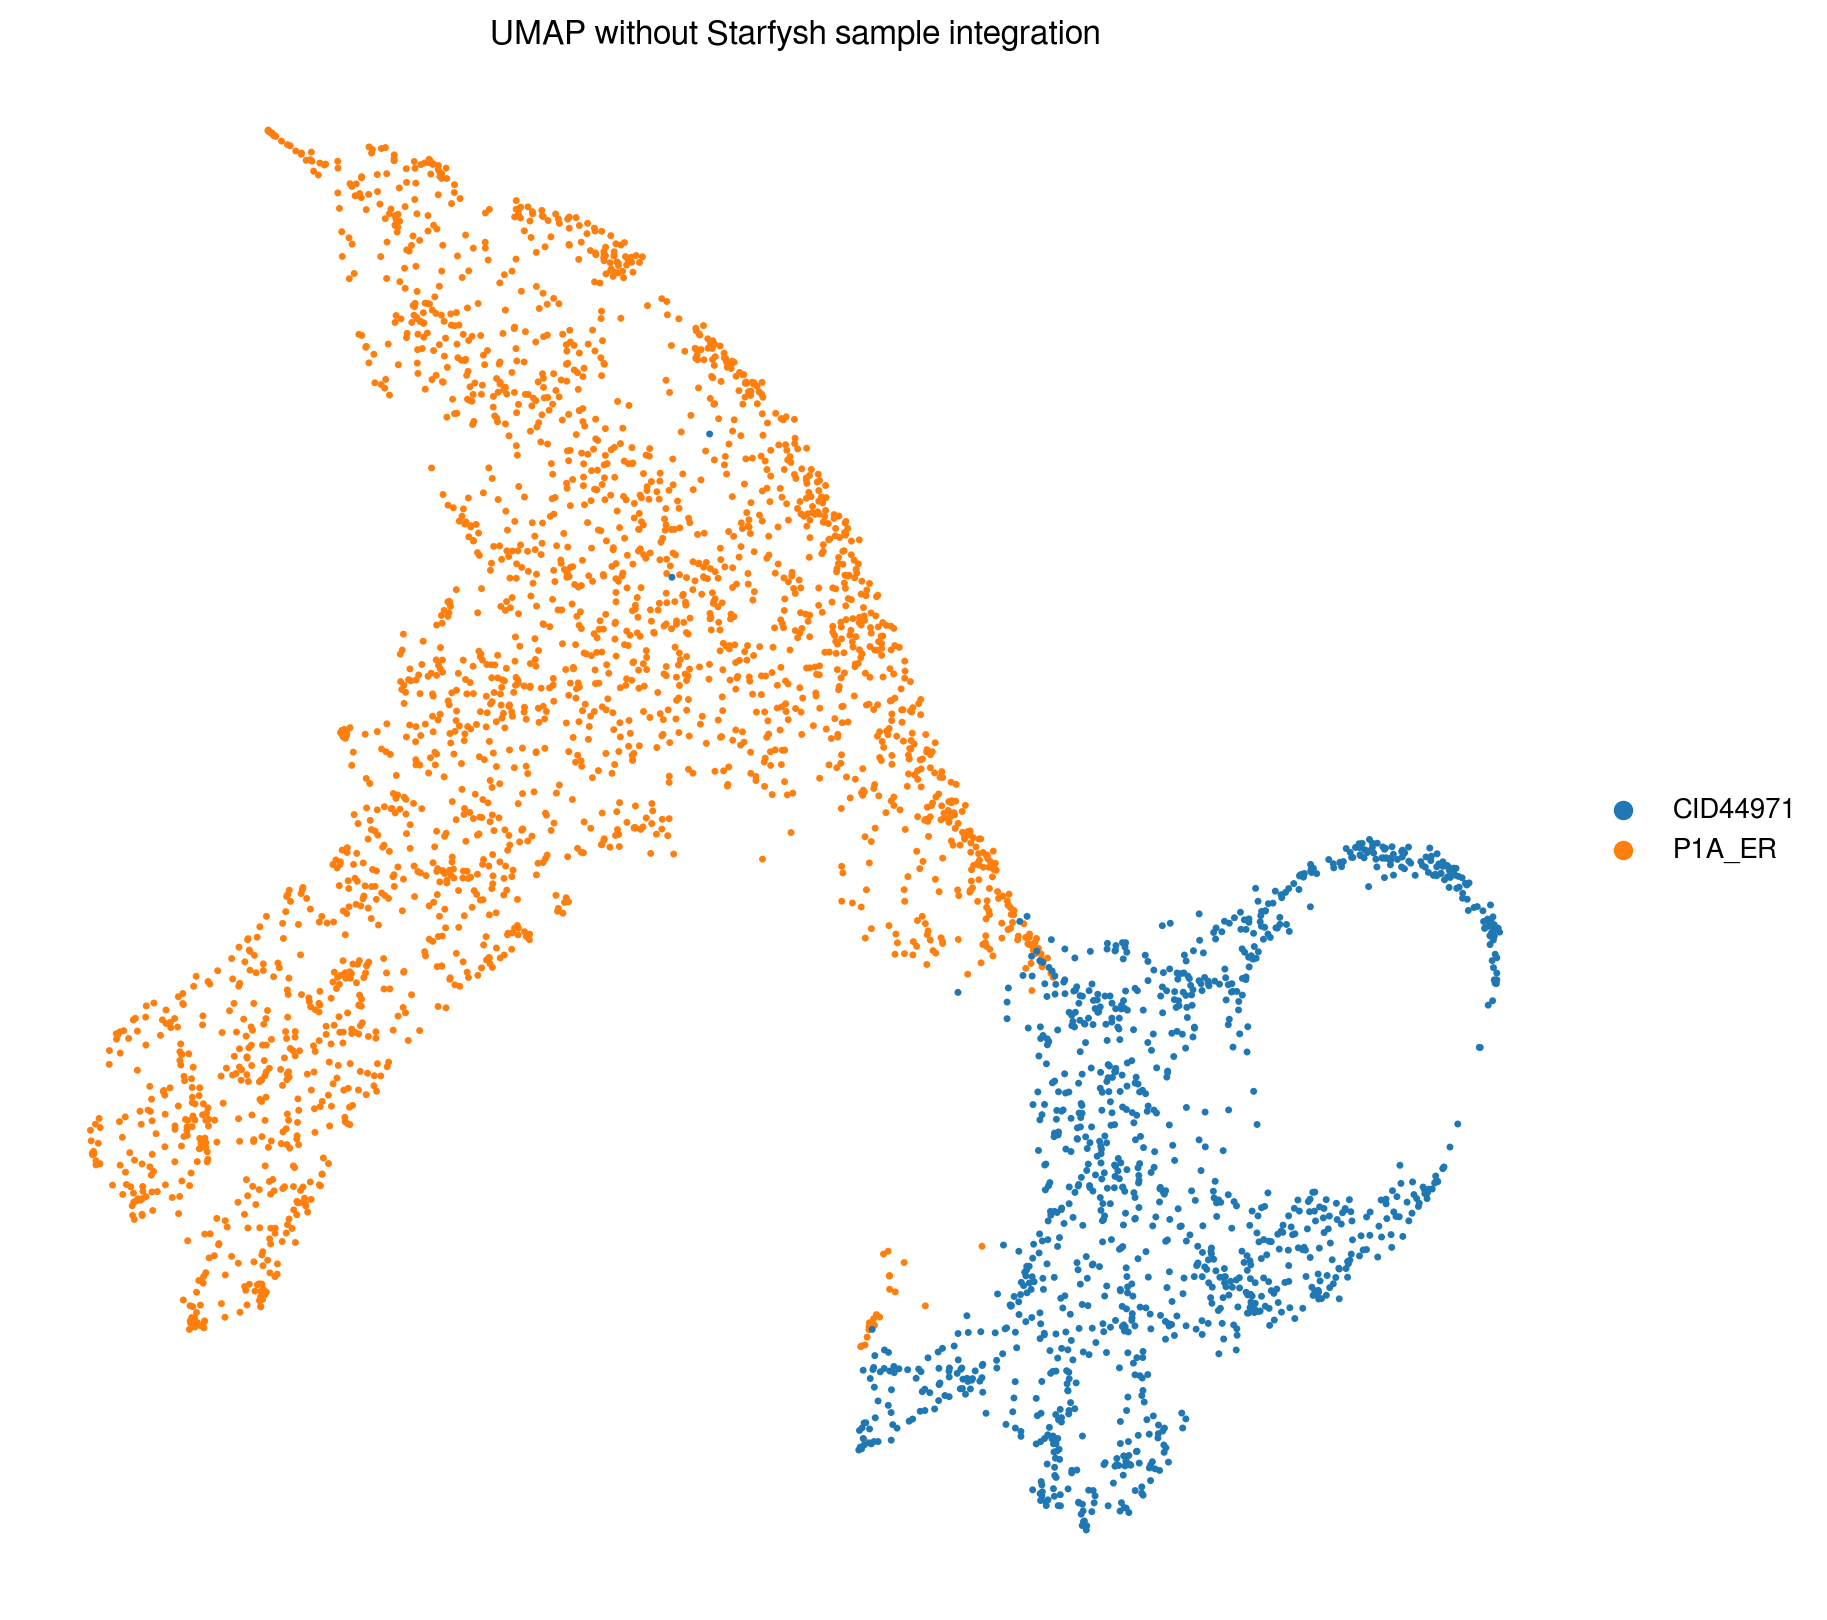

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=200)
ax = sc.pl.umap(adata_all, color='sample', 
               frameon=False, s=25, ax=ax,
               title='UMAP without Starfysh sample integration'
              )

In [110]:
# After integration
adata_integrate_starfysh.obs[gene_sig.columns]=pd.DataFrame(adata_integrate_starfysh.obsm['qc_m'],
                                                   columns=gene_sig.columns,
                                                   index=adata_integrate_starfysh.obs_names)
sc.pp.neighbors(adata_integrate_starfysh, use_rep='qc_m', n_neighbors=20)
sc.tl.umap(adata_integrate_starfysh,  min_dist=0.2)

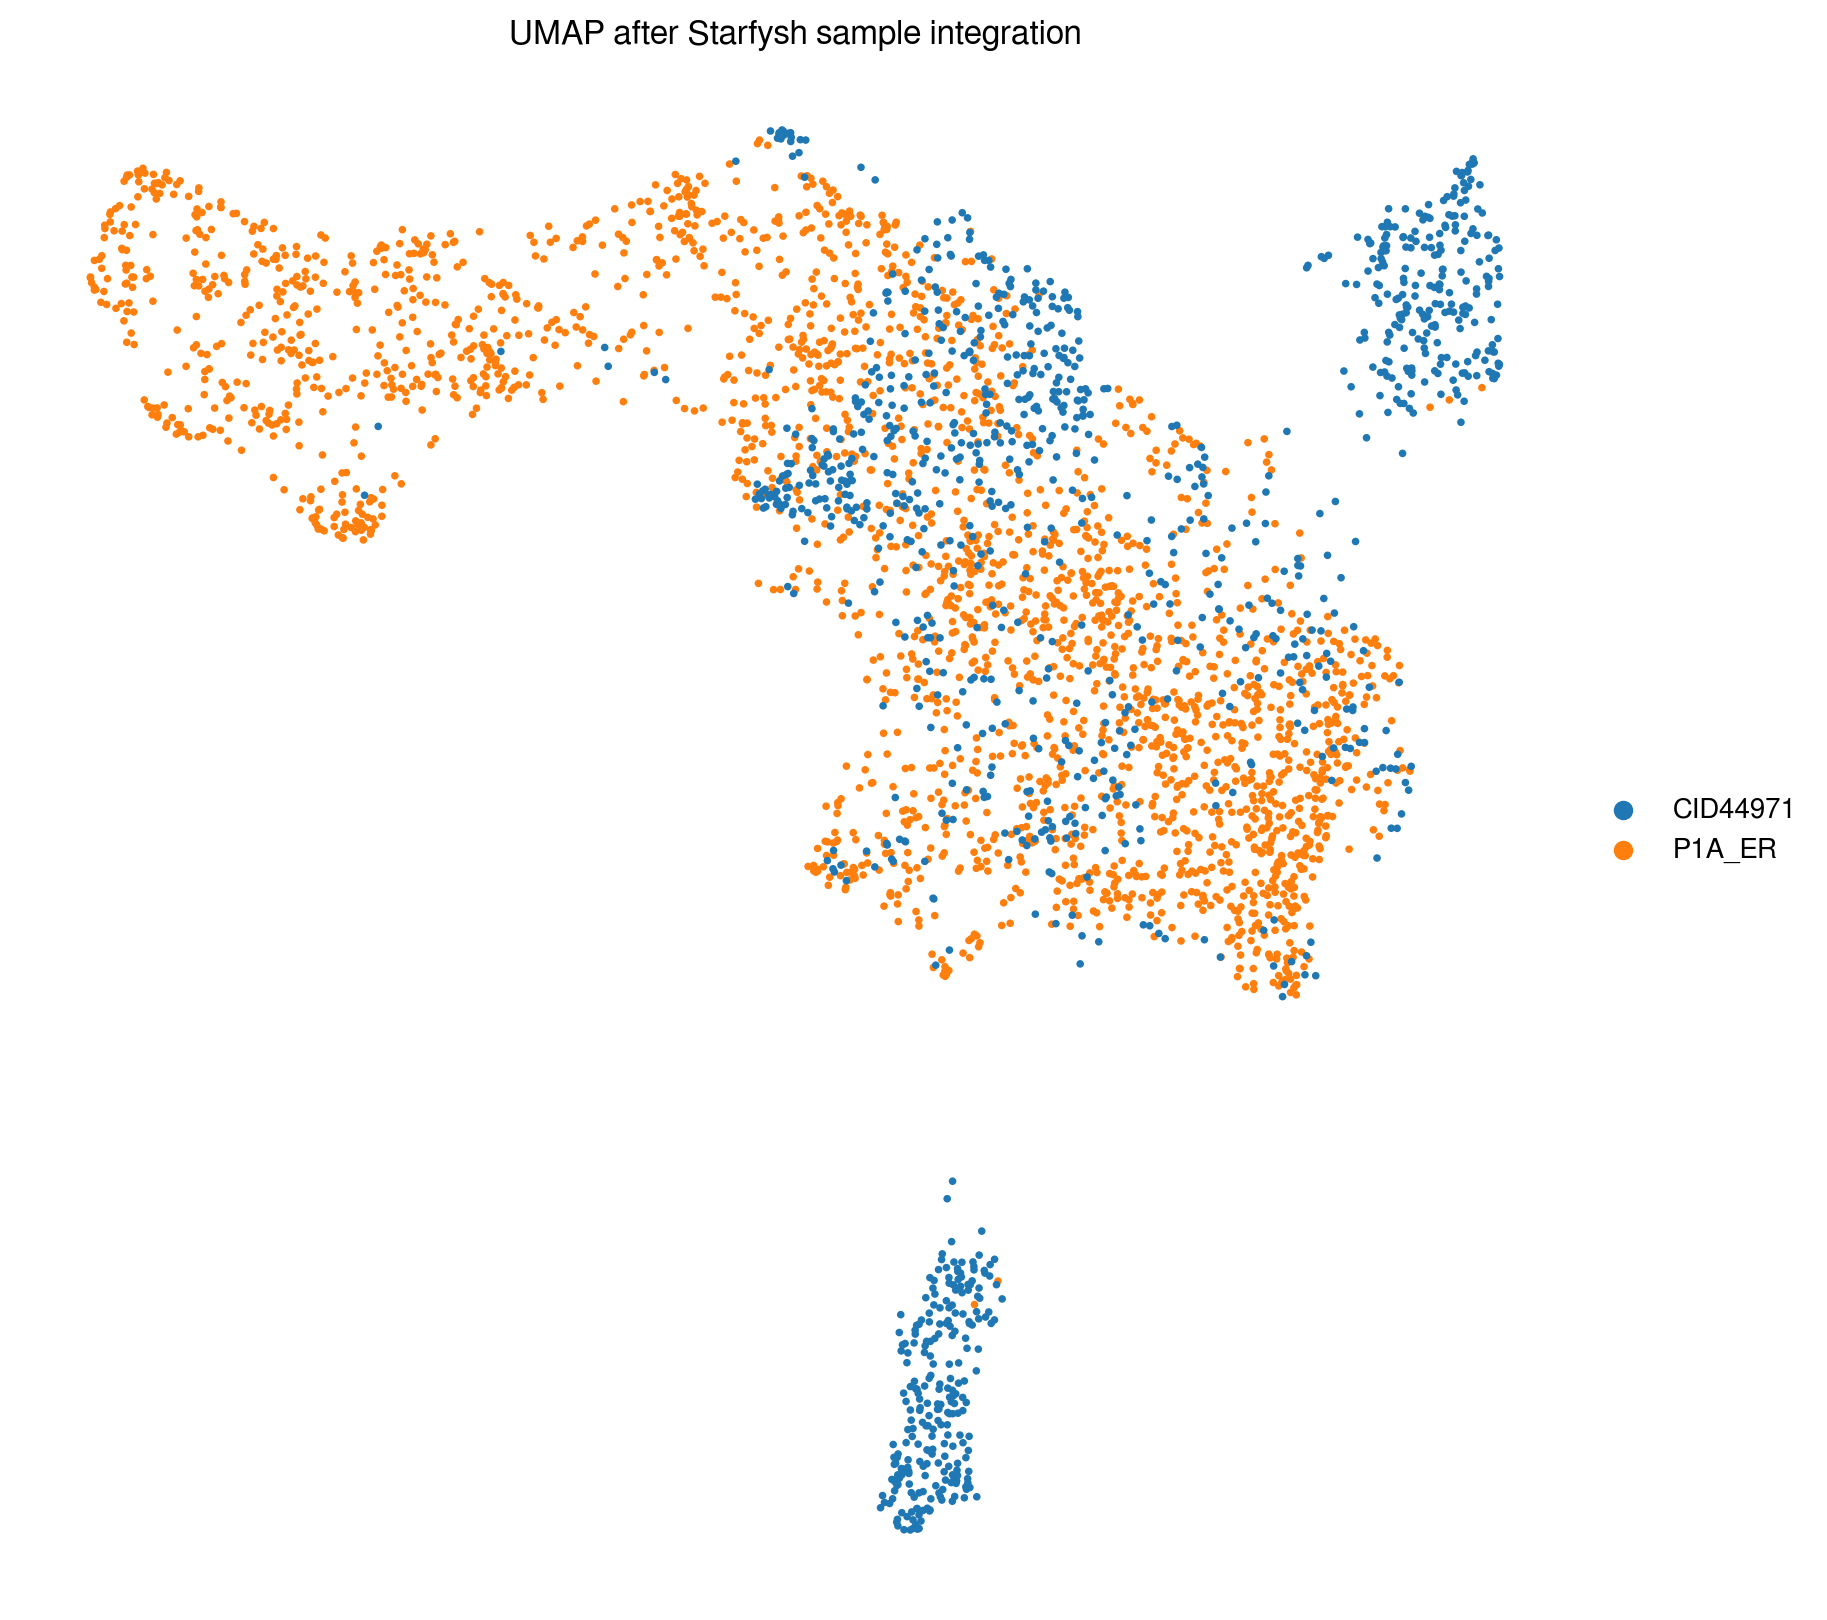

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=200)
ax = sc.pl.umap(adata_integrate_starfysh,color='sample',
                frameon=False, s=30, ax=ax,
                title='UMAP after Starfysh sample integration'
                )

plt.show()

It's observed that Starfysh's integration through learnt `qc` embedding space corrected for batch-effects introduced by different samples / tumor subtypes via joint deconvolution

#### Display deconvolution profiles


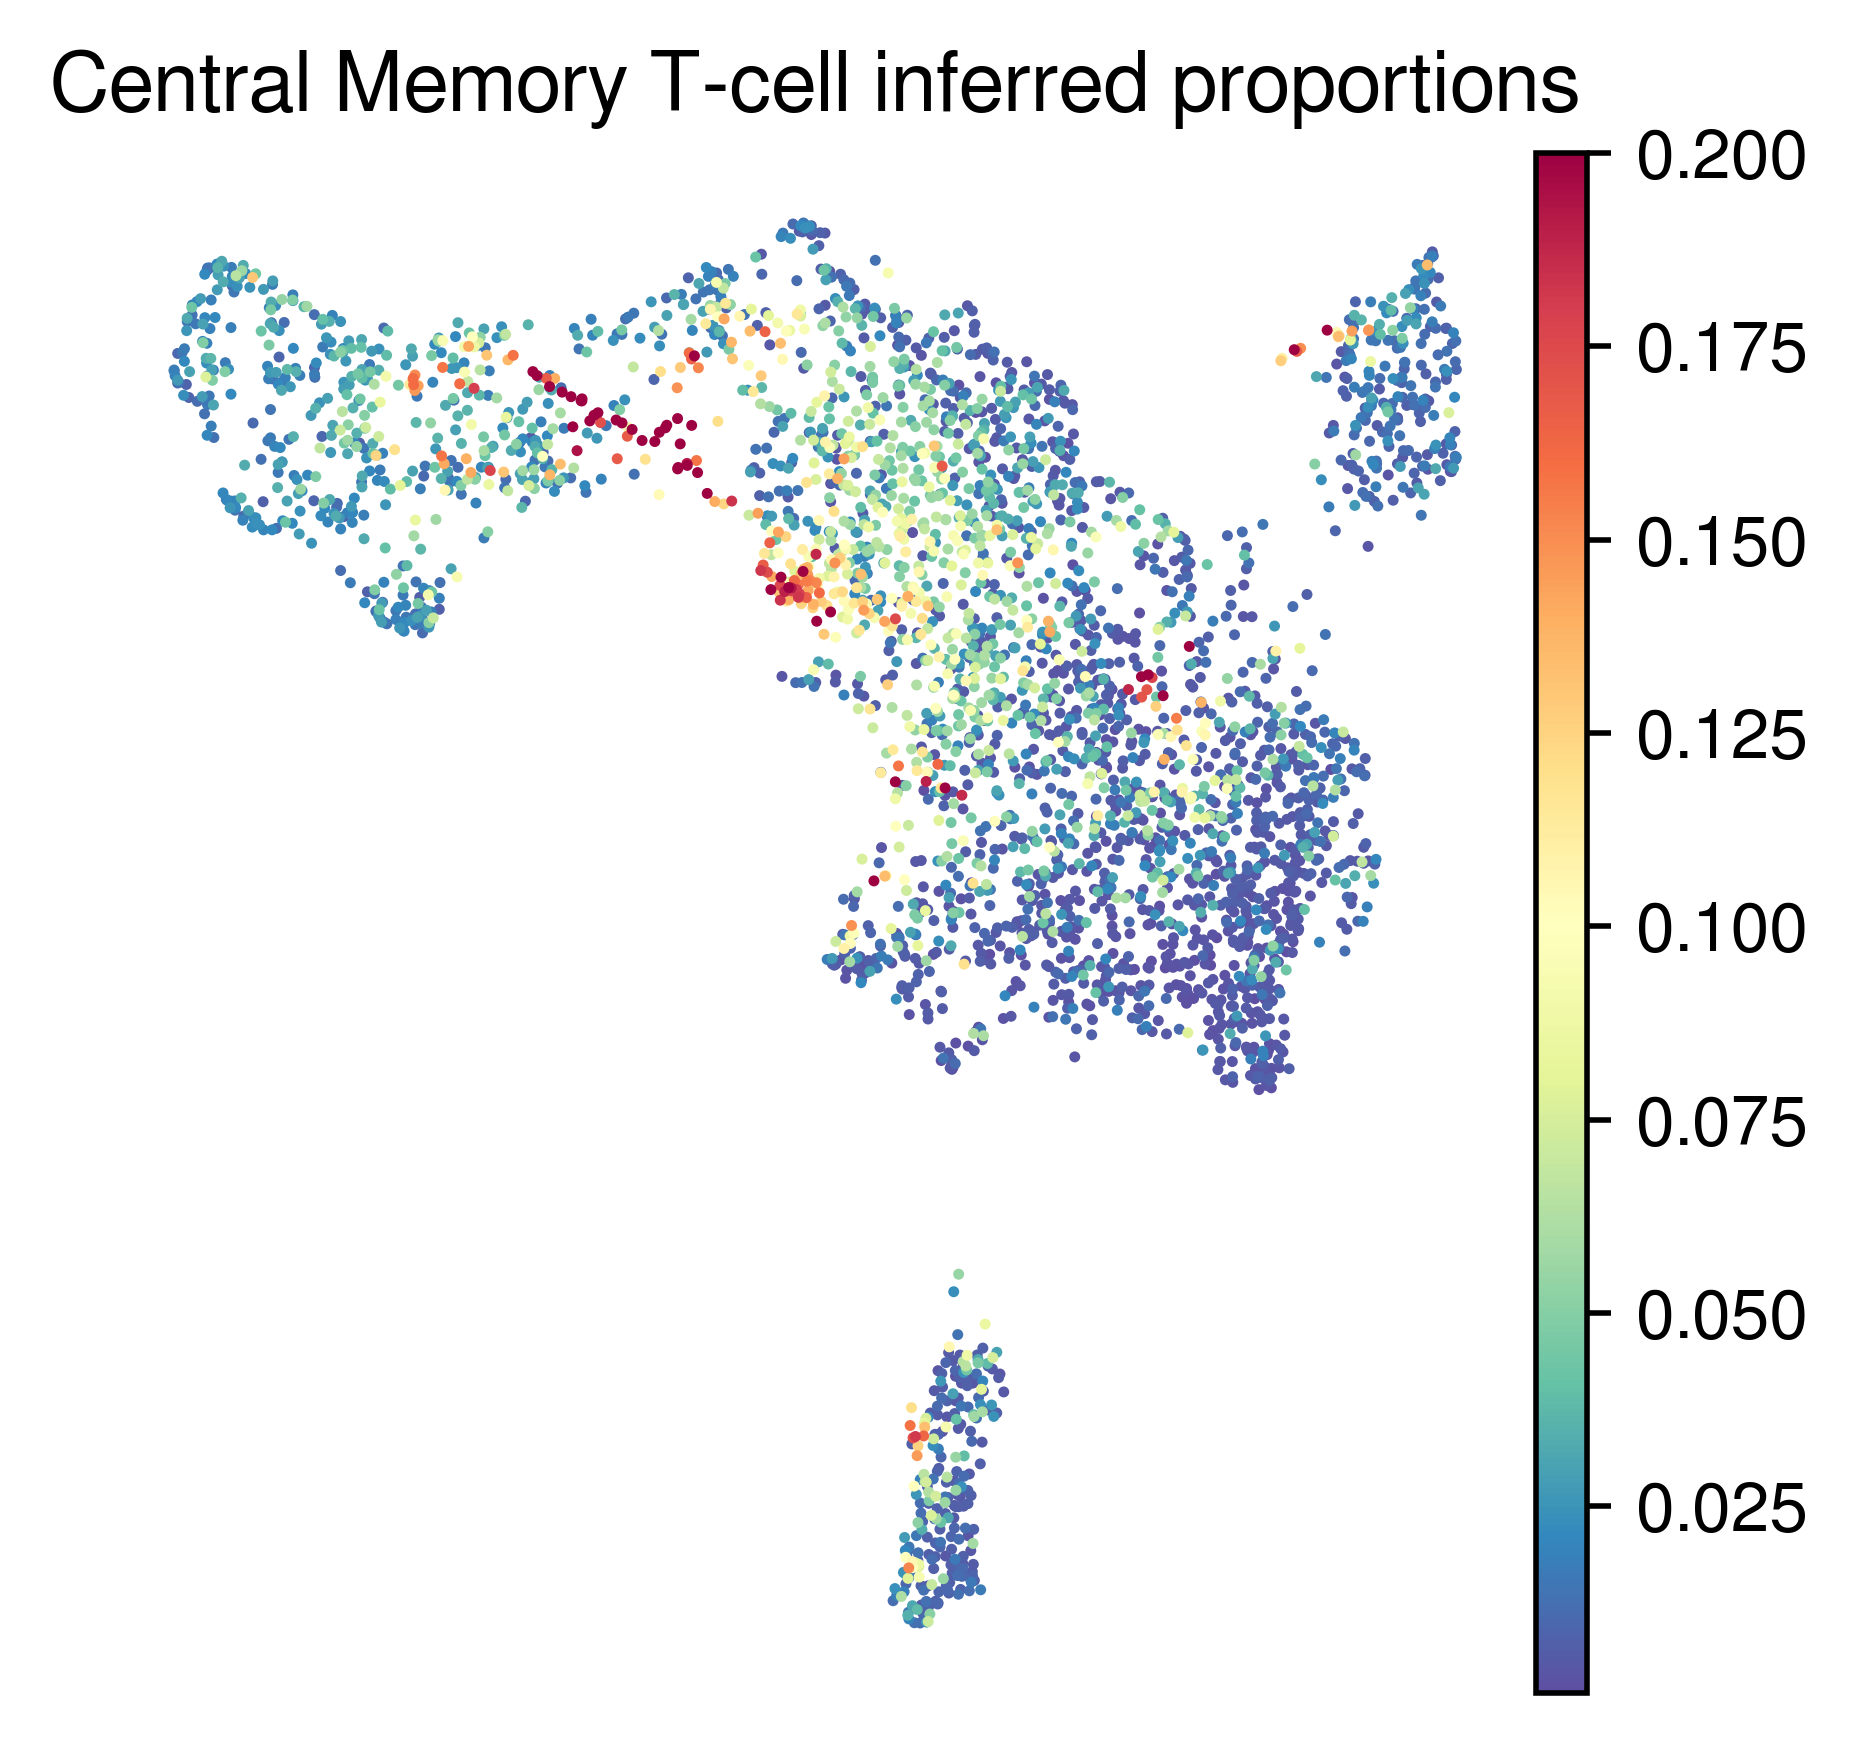

In [112]:
fig, ax = plt.subplots(1, 1,figsize=(4, 4), dpi=500)
sc.pl.umap(adata_integrate_starfysh, color='Tcm',  
           frameon=False, vmax=0.2,
           s=10, cmap='Spectral_r', ax=ax,
           title='Central Memory T-cell inferred proportions'
          )
plt.show()

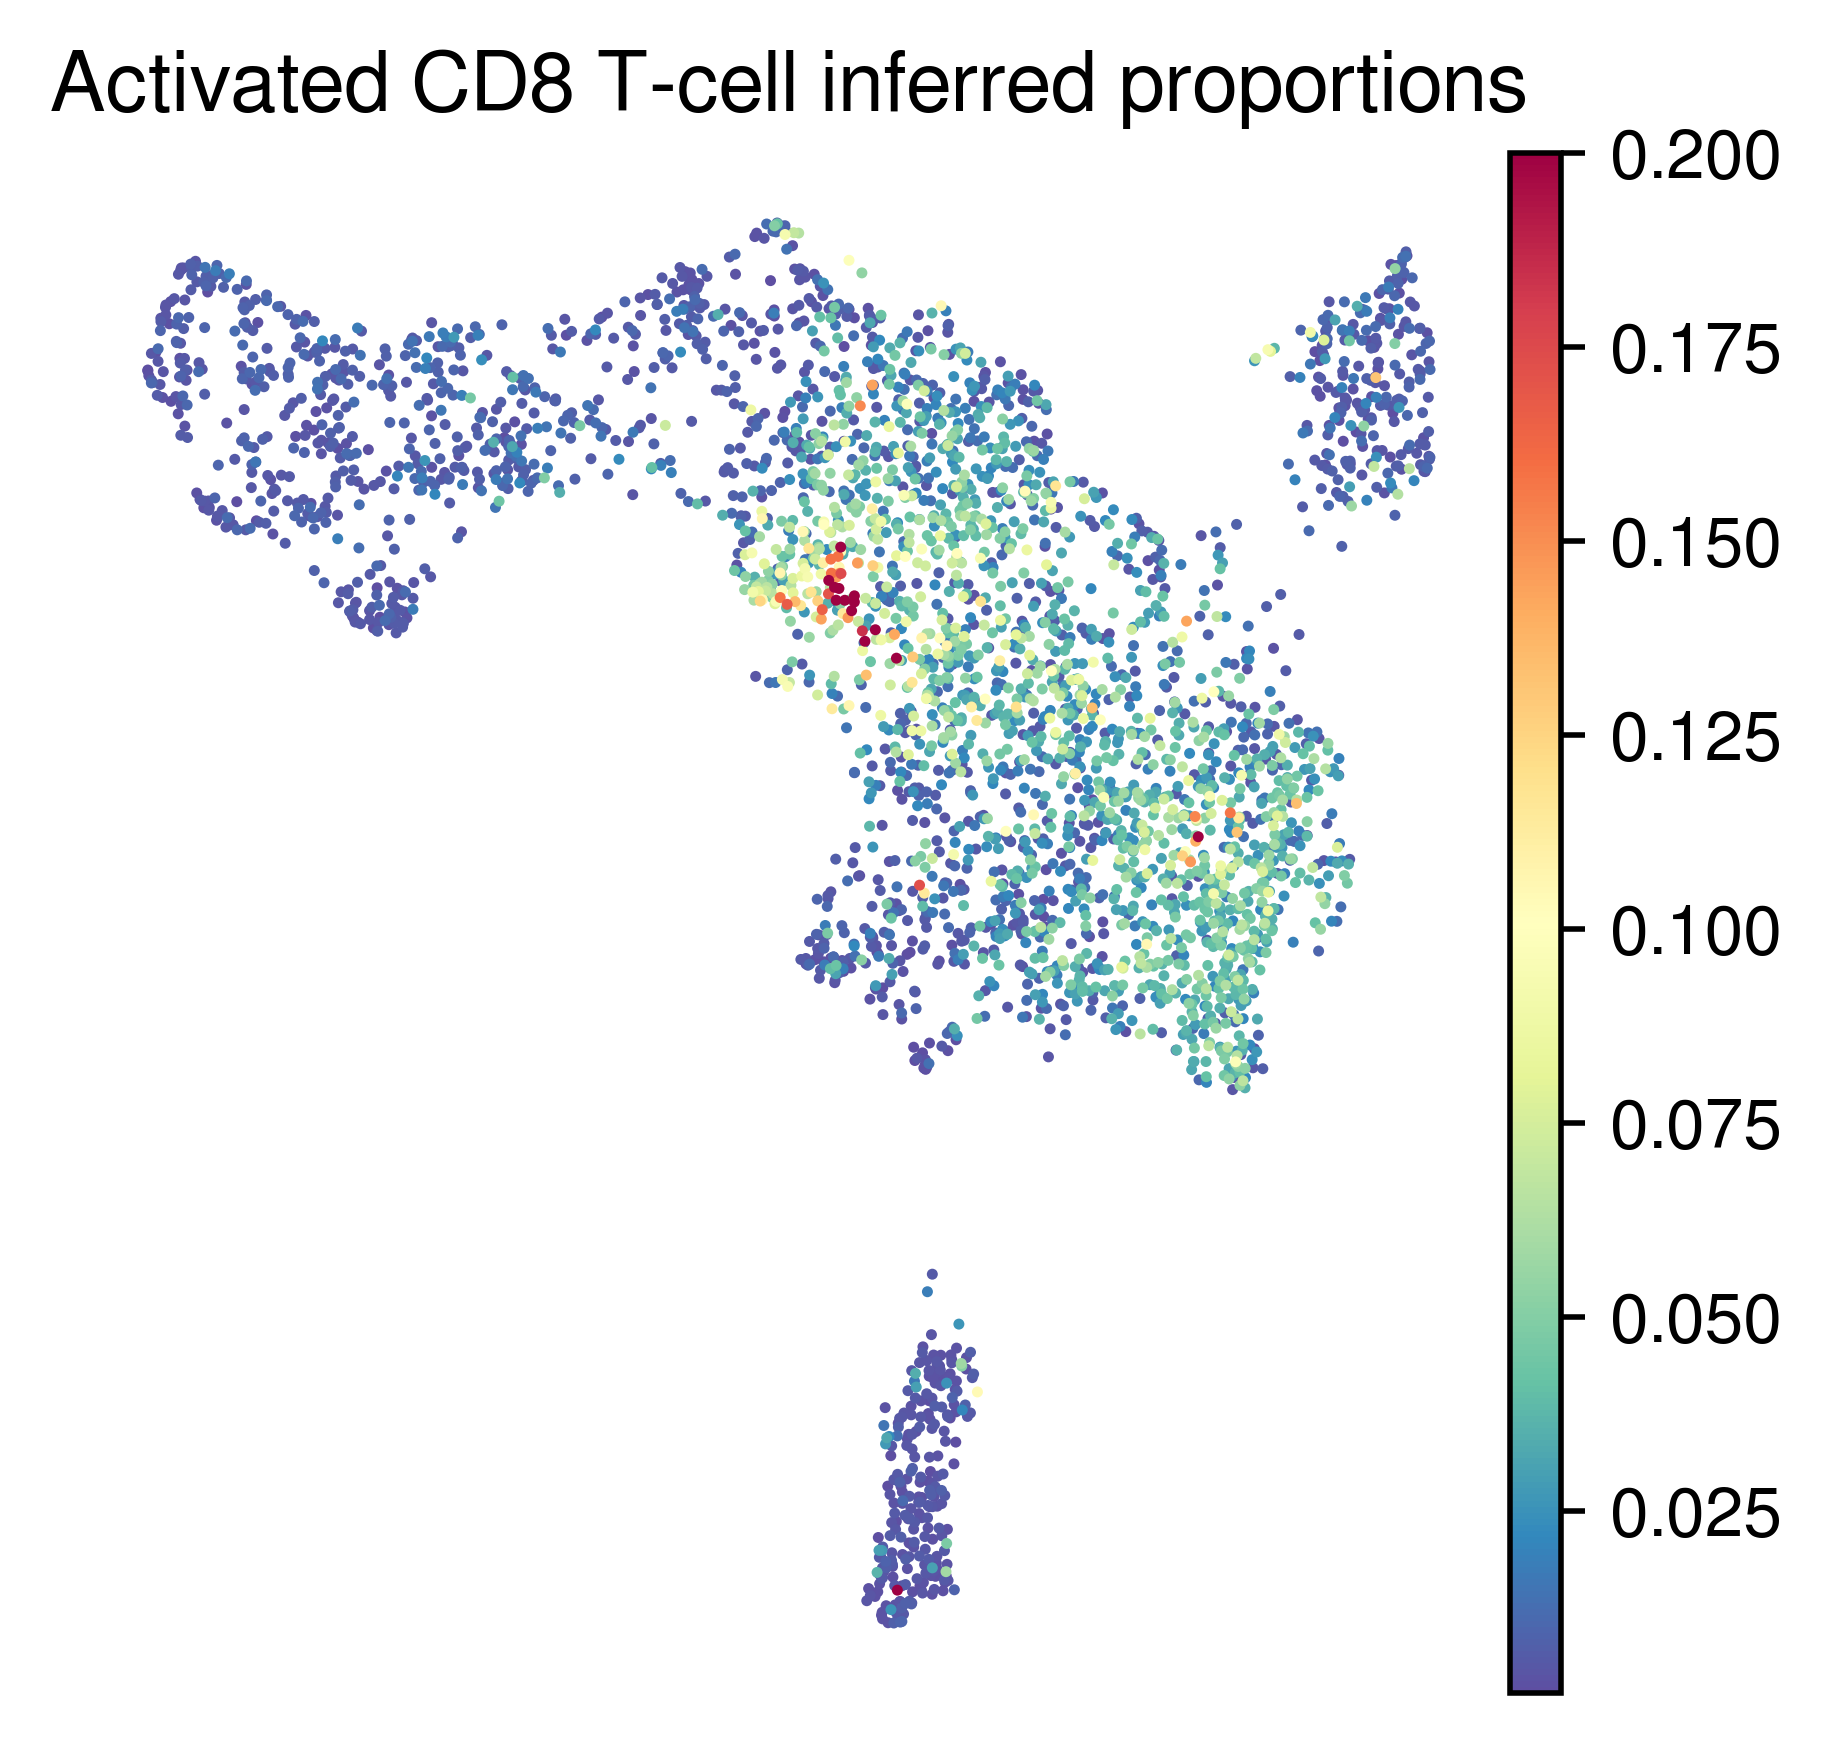

In [113]:
fig, ax = plt.subplots(1, 1,figsize=(4, 4), dpi=500)
sc.pl.umap(adata_integrate_starfysh, color='Activated CD8',  
           frameon=False, vmax=0.2,
           s=10, cmap='Spectral_r', ax=ax,
           title='Activated CD8 T-cell inferred proportions'
          )
plt.show()

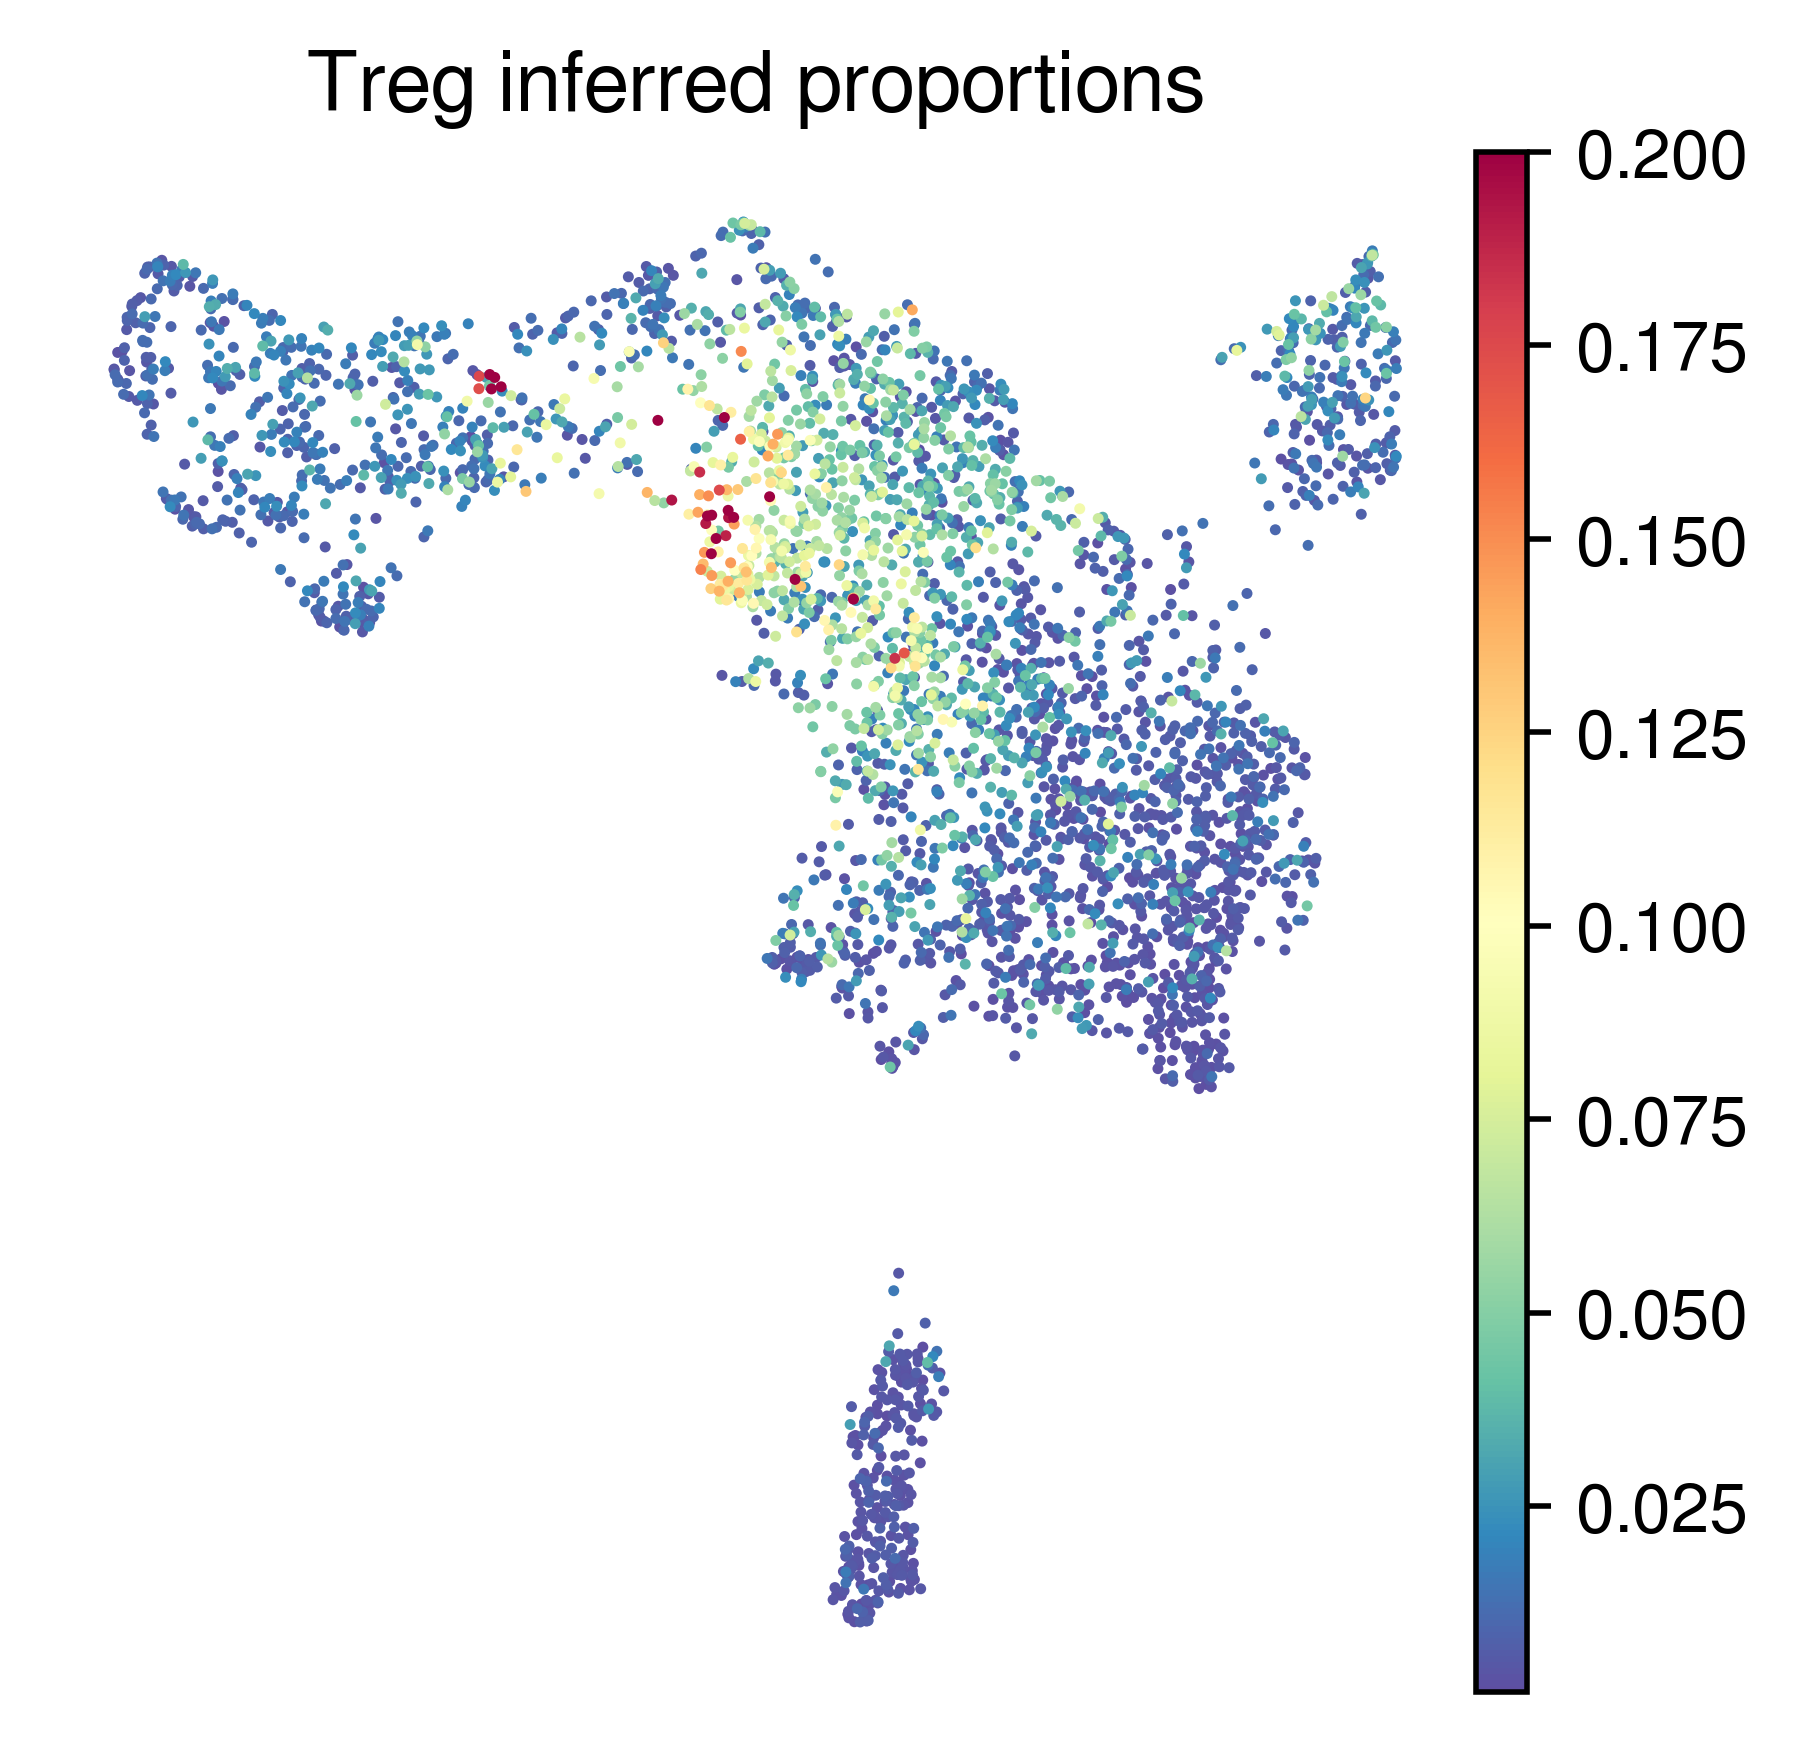

In [114]:
fig, ax = plt.subplots(1, 1,figsize=(4, 4), dpi=500)
sc.pl.umap(adata_integrate_starfysh, color='Treg',  
           frameon=False, vmax=0.2,
           s=10, cmap='Spectral_r', ax=ax,
           title='Treg inferred proportions'
          )
plt.show()

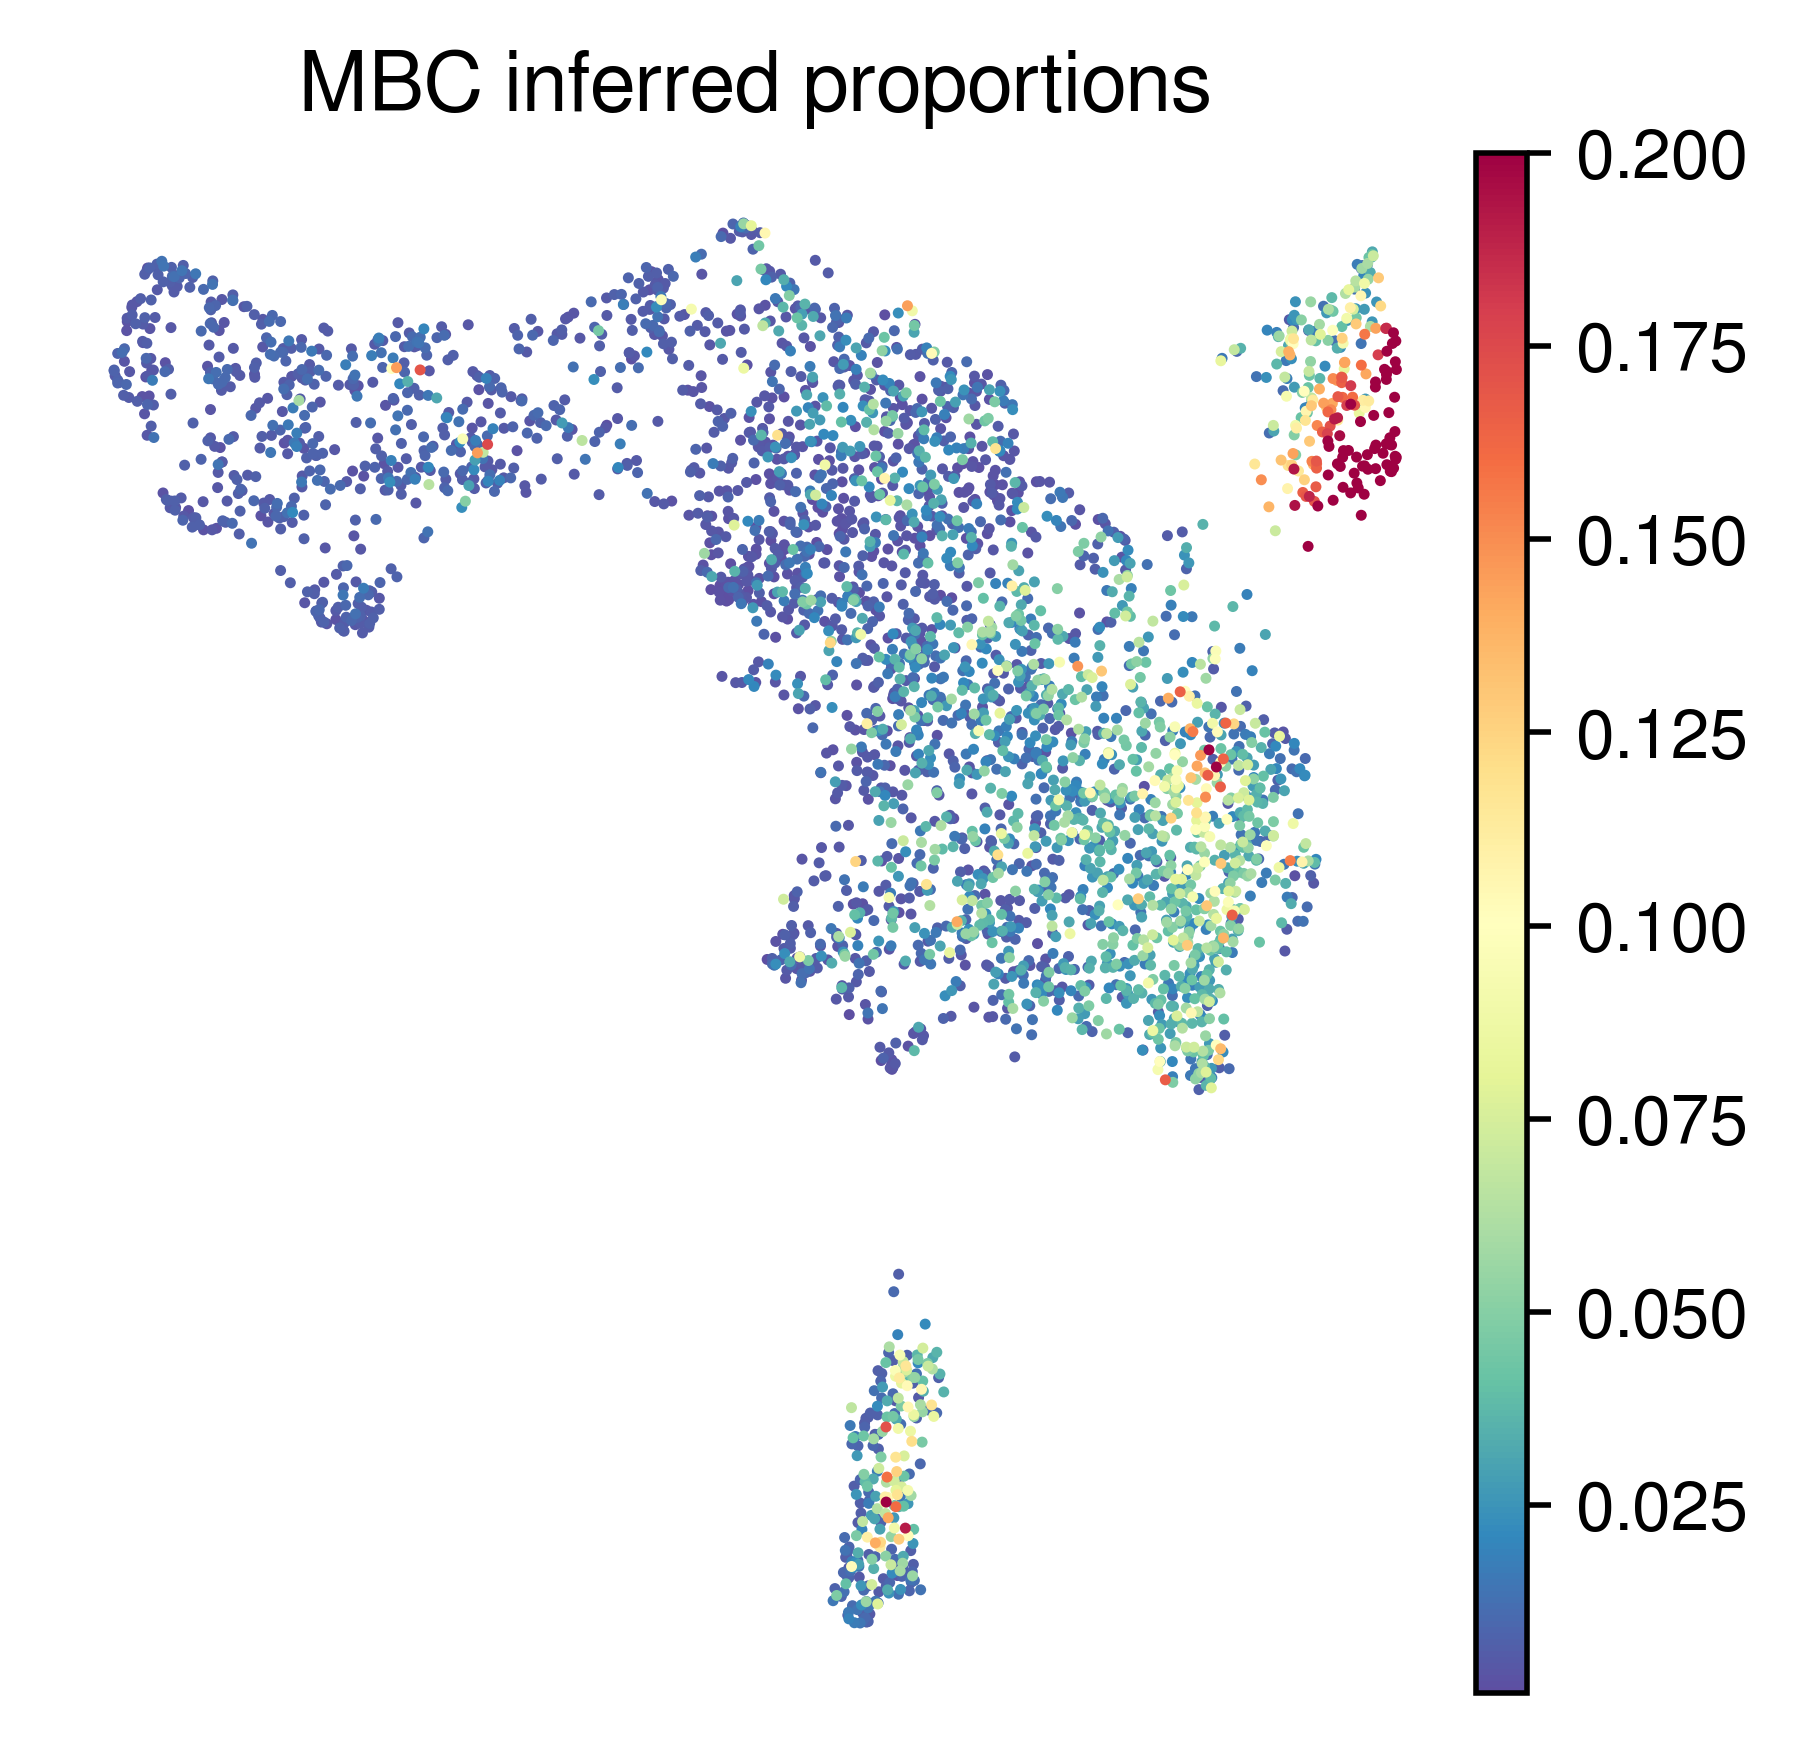

In [115]:
fig, ax = plt.subplots(1, 1,figsize=(4, 4), dpi=500)
sc.pl.umap(adata_integrate_starfysh, color='MBC',  
           frameon=False, vmax=0.2,
           s=10, cmap='Spectral_r', ax=ax,
           title='MBC inferred proportions'
          )
plt.show()

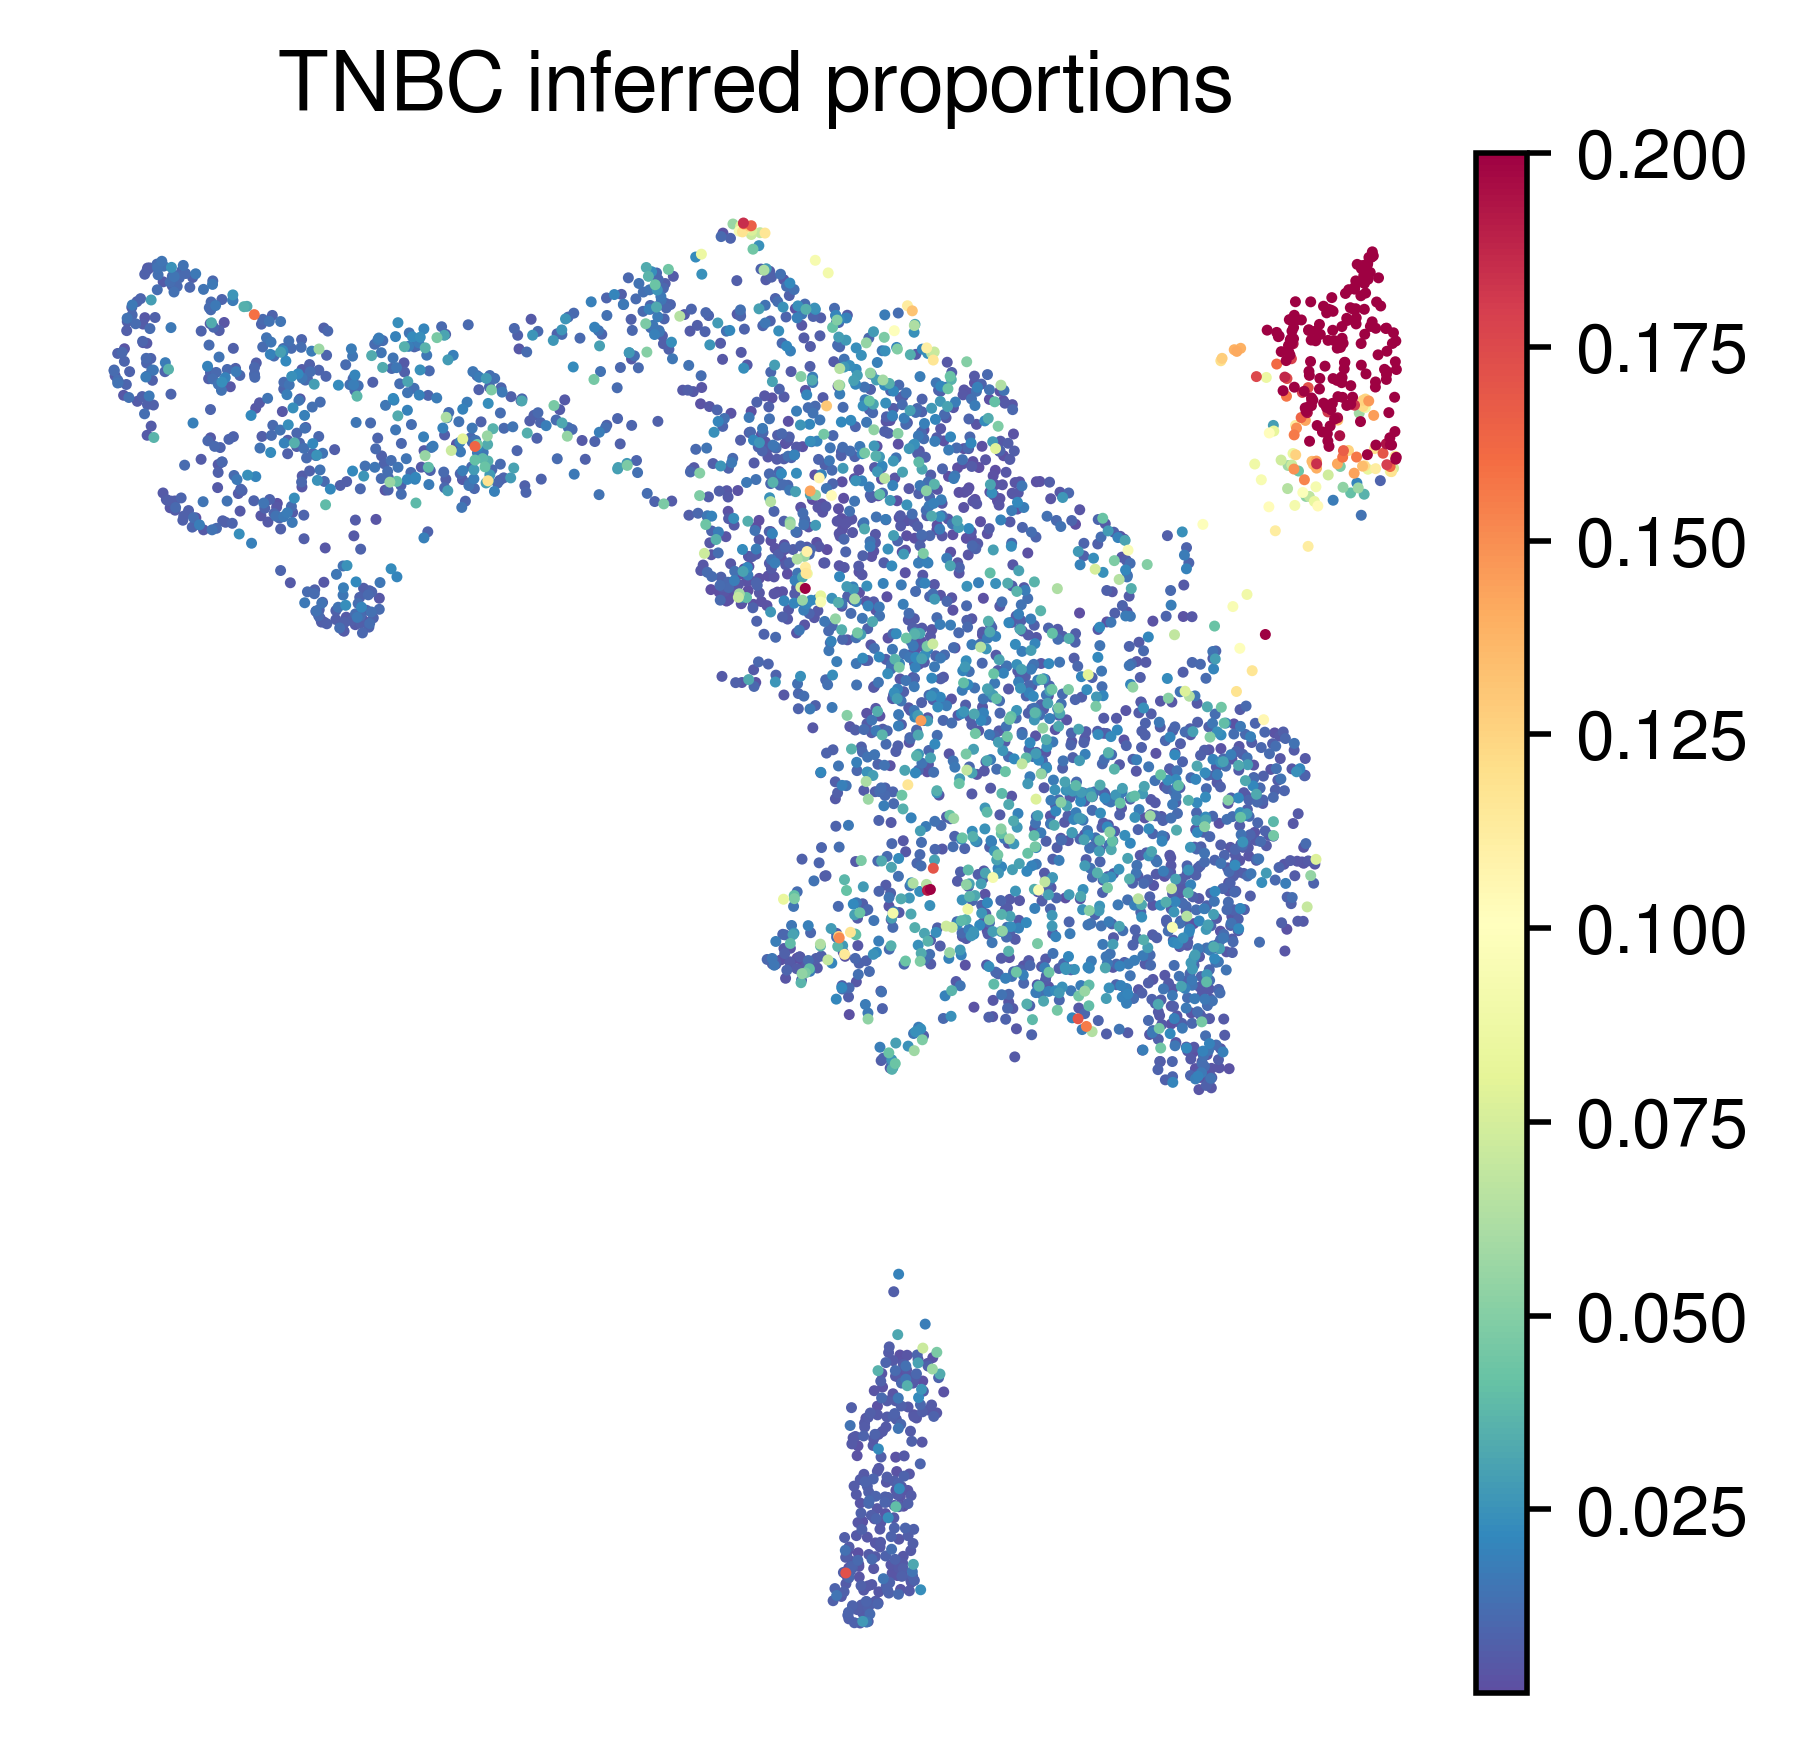

In [116]:
fig, ax = plt.subplots(1, 1,figsize=(4, 4), dpi=500)
sc.pl.umap(adata_integrate_starfysh, color='Basal',  
           frameon=False, vmax=0.2,
           s=10, cmap='Spectral_r', ax=ax,
           title='TNBC inferred proportions'
          )
plt.show()

#### Spatial Hub calculation

In [117]:
adata_integrate_starfysh

AnnData object with n_obs × n_vars = 3616 × 4698
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'patient', 'sample_type', 'Basal', 'LumA', 'LumB', 'MBC', 'CSC', 'Normal epithelial', 'Tcm', 'Tem', 'Tfh', 'Treg', 'Activated CD8', 'Deletional tolerance CD8', 'Dysfunc CD8', 'Terminal exhaustion', 'Precursor exhaustion', 'NK', 'B cells memory', 'B cells naive', 'Macrophage M1', 'Macrophage M2', 'Plasmablasts', 'MDSC', 'Monocytes', 'cDC', 'pDC', 'CAFs MSC iCAF-like', 'CAFs myCAF-like', 'PVL differentiated', 'PVL immature', 'Endothelial'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'cell_types', 'spatial', 'qu', 'neighbors', 'umap', 'sample_colors'
    obsm: 'spatial', 'px', 'qc_m', 'qc', 'qz_m', 'qz_m_ct', 'qz_lo

In [123]:
import scanpy.external as sce

# this step is necessary since we replace qc_m or qz_m as the X_pca for clustering by phenograph
adata_integrate_starfysh.obsm["X_pca"] = adata_integrate_starfysh.obsm['qc_m']

sc.pp.neighbors(adata_integrate_starfysh, use_rep = 'X_pca')
#sc.tl.leiden(adata_integrate_starfysh)


In [133]:
# Calculate hubs via Phenograph clustering
sce.tl.phenograph(adata_integrate_starfysh, clustering_algo="louvain",k=50)
adata_integrate_starfysh.obs['hub'] = adata_integrate_starfysh.obs['pheno_louvain'].astype('category')
adata_integrate_starfysh.obs['hub']

Finding 50 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.15858078002929688 seconds
Jaccard graph constructed in 9.132378339767456 seconds
Wrote graph to binary file in 0.07030916213989258 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.773756
Louvain completed 21 runs in 3.6139137744903564 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 19.437910795211792 seconds


AAACACCAATAACTGC-1-P1A_ER      0
AAACAGCTTTCAGAAG-1-P1A_ER      6
AAACAGGGTCTATATT-1-P1A_ER      9
AAACATGGTGAGAGGA-1-P1A_ER      8
AAACCGGGTAGGTACC-1-P1A_ER      3
                              ..
TGCAGTGGTAGGGAAC-1-CID44971    0
AGCGAGACGTGAAGGC-1-CID44971    2
CAGTGTTAATCTCTCA-1-CID44971    2
GATCGCTGTGGTGCGT-1-CID44971    3
CTCTGCAGGCATTCTT-1-CID44971    1
Name: hub, Length: 3616, dtype: category
Categories (11, int64): [0, 1, 2, 3, ..., 7, 8, 9, 10]

In [130]:
## add color for your number of hubs
new_hub_colormap = [
    'red', #0
    'skyblue', #1
    'cornflowerblue',#2
    'cyan',#3
    'orchid',#4
    'slategray',#5
    'cadetblue',#6
    'orange',#7
    'palevioletred',#8
    'gold',#9
    'teal',#10
    'olive',#11
    'blueviolet',#12
    'blue',#13
    'darkslateblue',#14
    'limegreen',#15
    'yellowgreen',#16
    'linen',#17
    'mistyrose',#18
    'wheat',#19
    'darkturquoise',#20
    'lime',#21
    'hotpink',#22
]

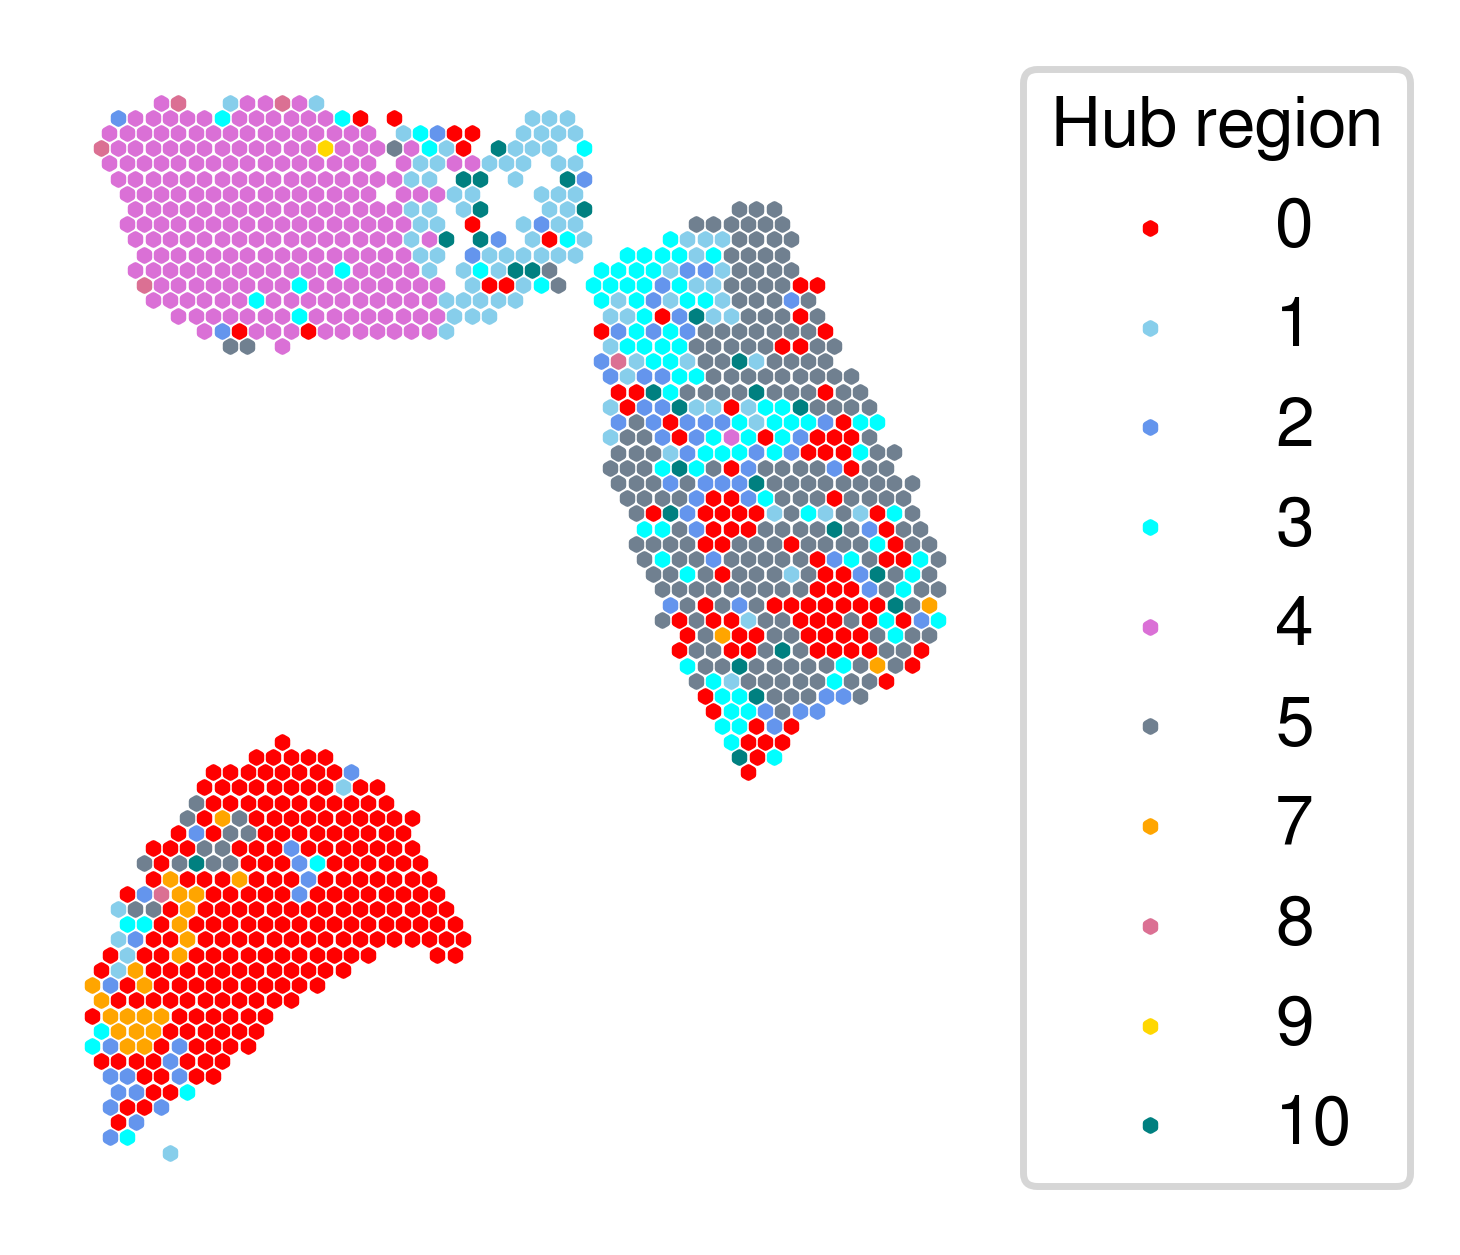

In [136]:
plot_utils.plot_integrated_spatial_feature(data = adata_integrate_starfysh,
                                           sample_id = 'CID44971',
                                           spot_size=2,
                                           figsize=(2.4,3),
                                           cmap = new_hub_colormap,
                                           legend_on = True,
                                           legend_loc =(1.5,0.5)  # adjust based on your figure
                                          )

### For other plot as no integration, just subset adata_integrate_starfysh[sample_id]

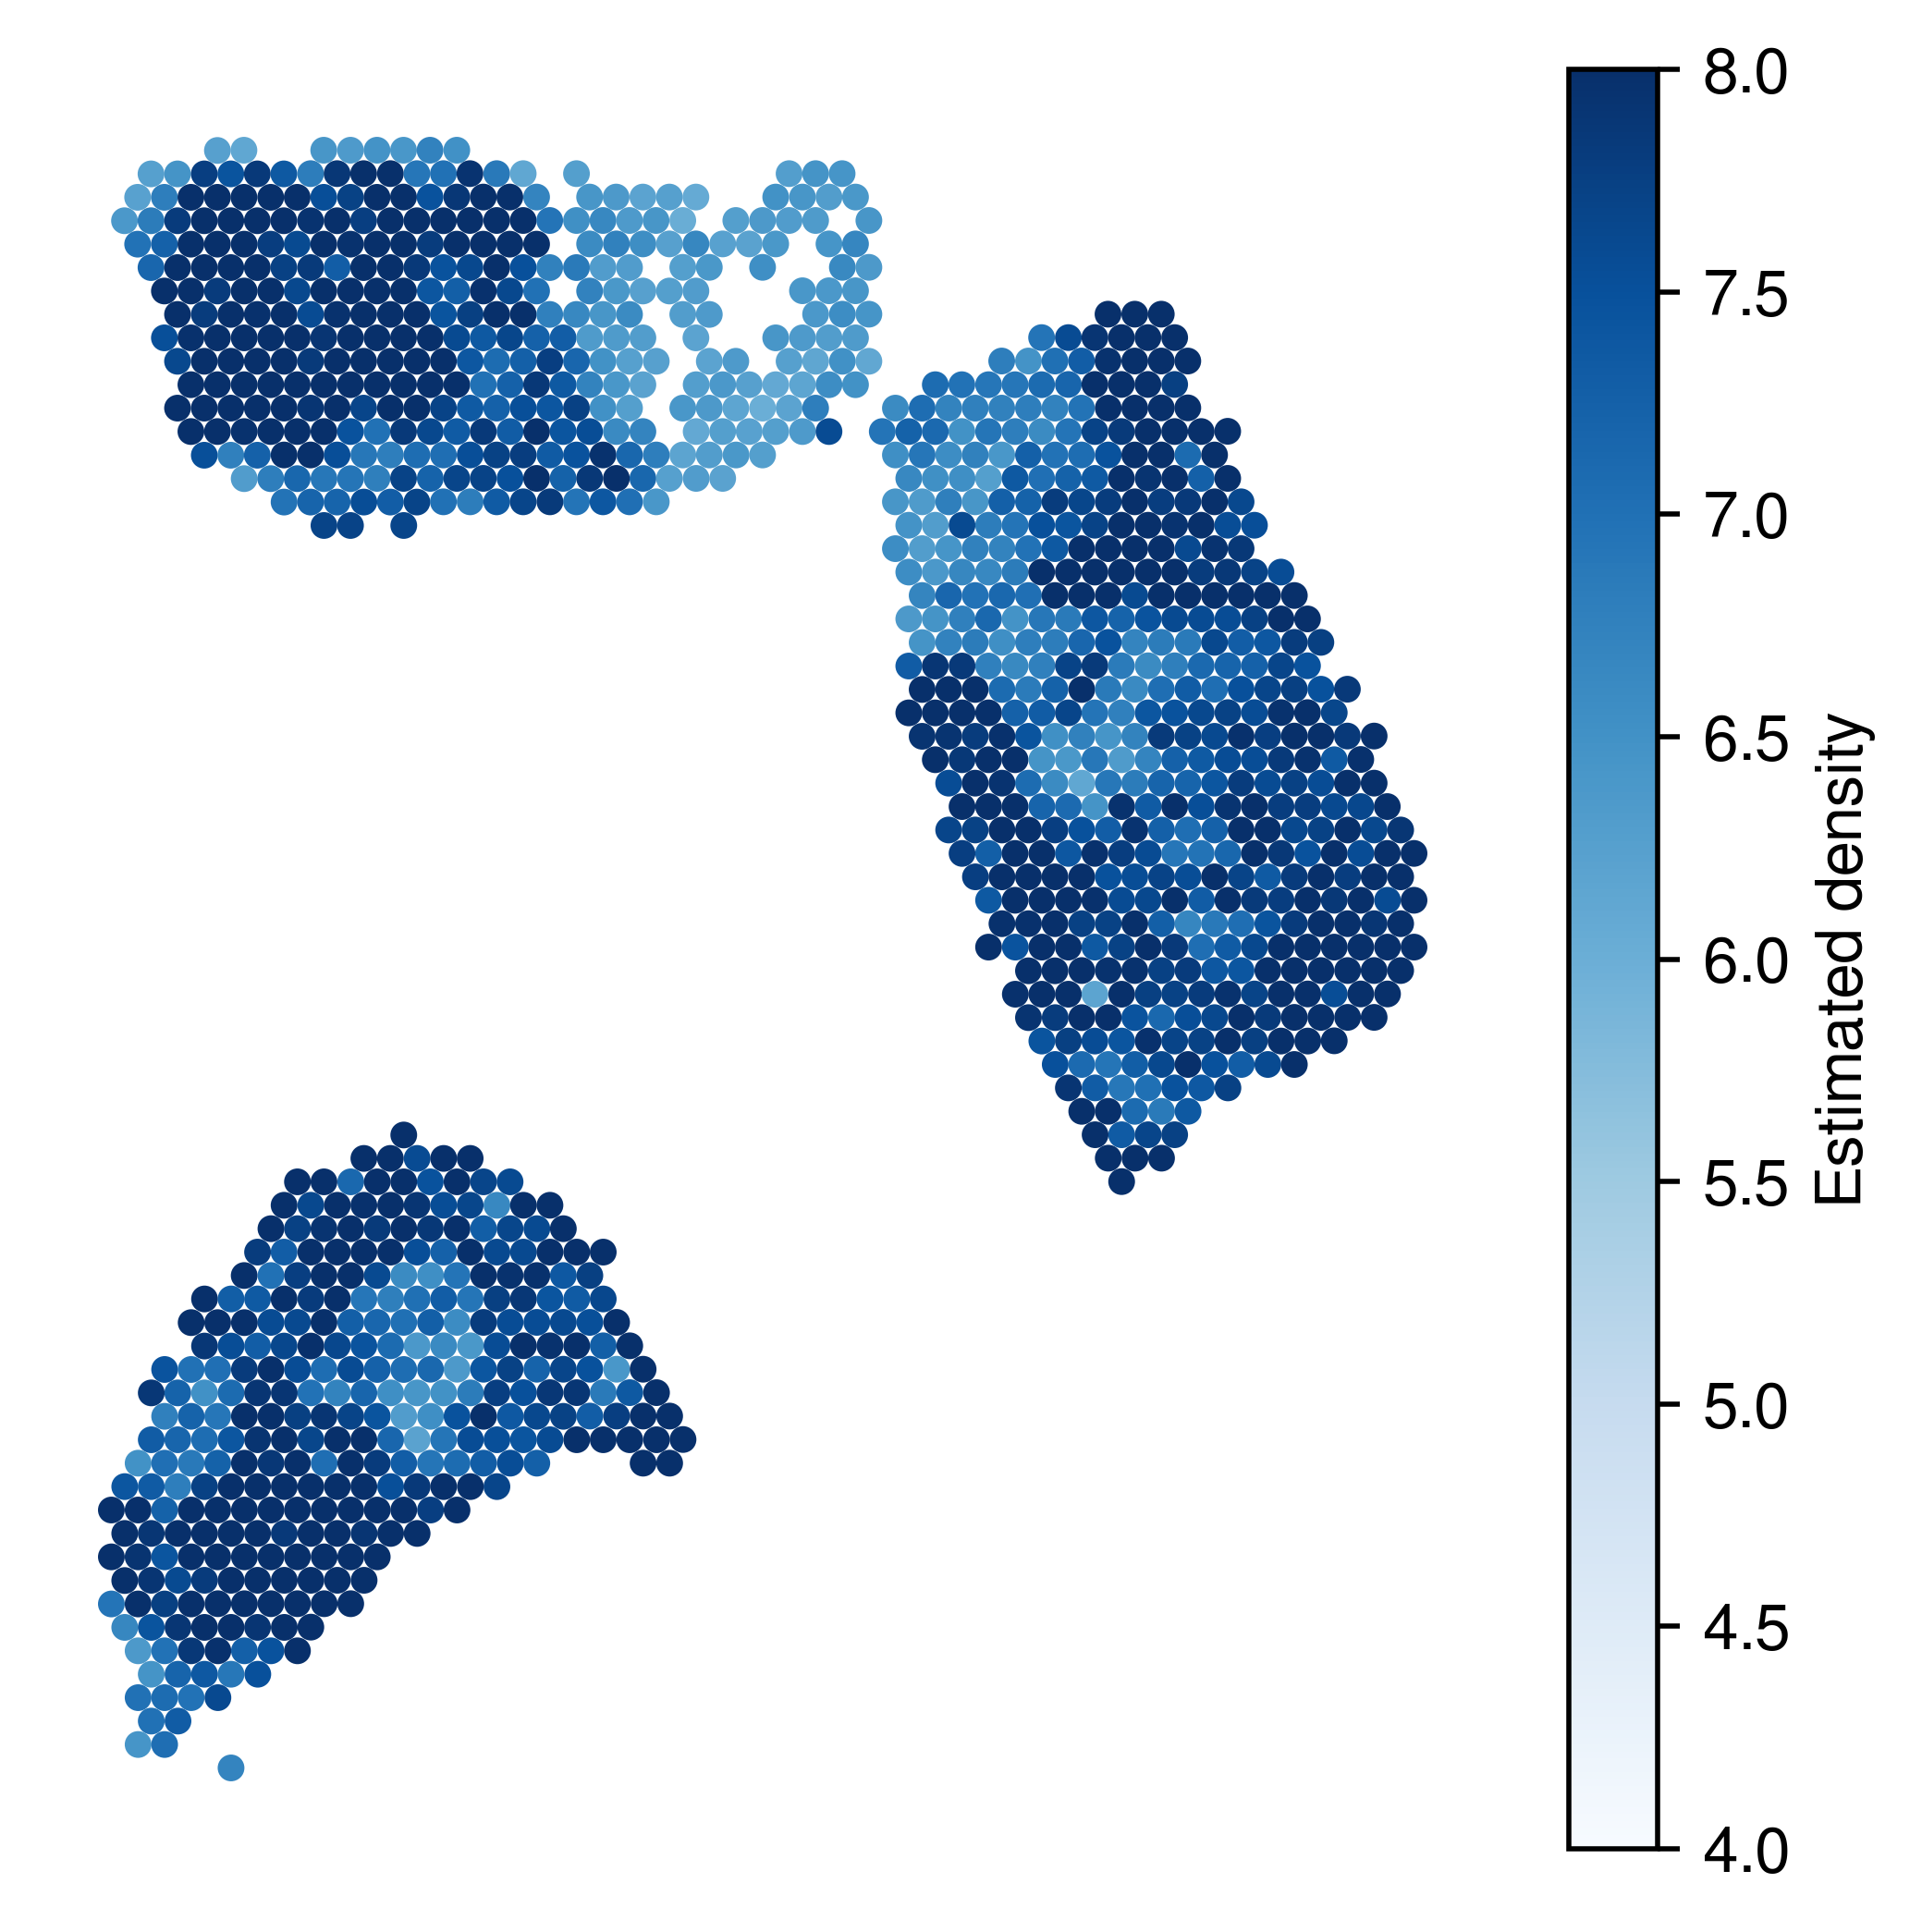

In [140]:
plot_utils.plot_spatial_density(data = adata_integrate_starfysh[adata_integrate_starfysh.obs['sample']=='CID44971'], 
                                vmin = 4, 
                                vmax = 8,
                                spot_size = 10,
                                figsize = (5,5),
                                fig_dpi = 500,
                                cmap = 'Blues',
                                colorbar_on = True
                               )


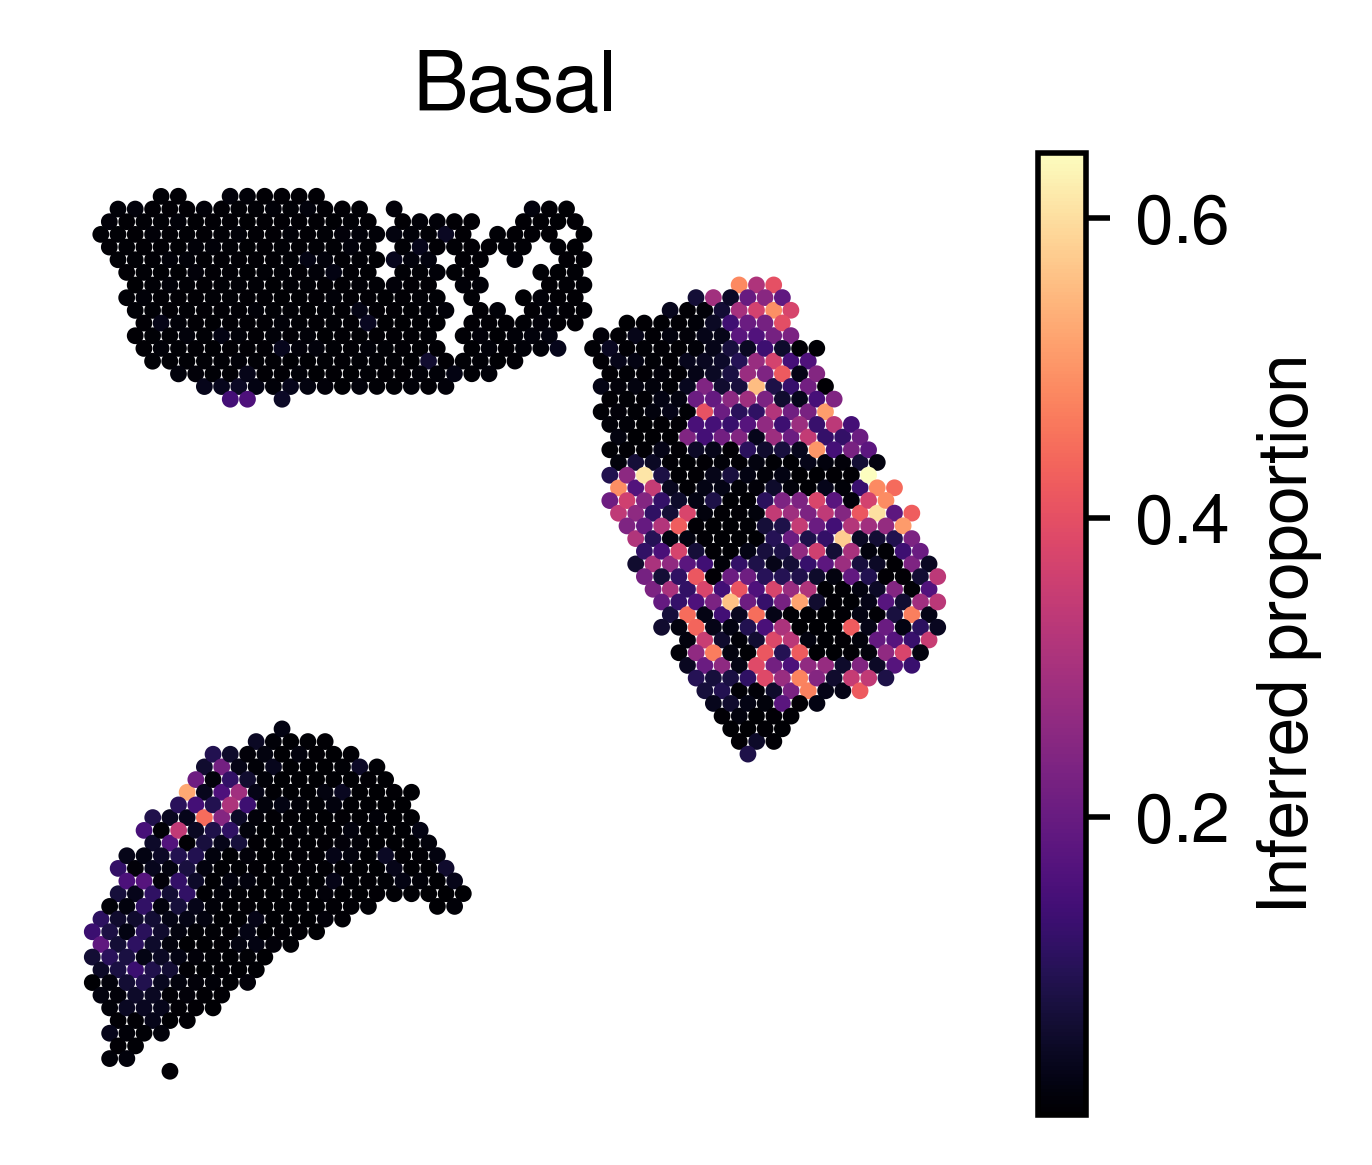

In [141]:
plot_utils.plot_spatial_cell_type_frac(  data = adata_integrate_starfysh[adata_integrate_starfysh.obs['sample']=='CID44971'], 
                                         cell_type = 'Basal',
                                         vmin=None,# adjust 
                                         vmax=None,# adjust 
                                         spot_size=2,# adjust 
                                         figsize = (3,2.5),
                                         fig_dpi = 500, # >300 for high quality img
                                         cmap = 'magma', 
                                         colorbar_on = True,
                                         title = None,#'Basal' or other customized title for figure
                                         label='Inferred proportion'
                        )

## please let us know if you have questions or want more visualization

email us: 

Siyu He - siyuhe@stanford.edu
Yinuo Jin - yj2589@columbia.edu

---